# Initialize some classes and namespaces

In [2]:
import numpy as np
import os
import collections
import csv
from matplotlib import cm
import matplotlib.pyplot as plt
classes = ['CALsuburb', 'MIThighway', 'MITopencountry', 'PARoffice', 'livingroom', \
            'MITcoast', 'MITinsidecity', 'MITstreet', 'bedroom', \
            'MITforest', 'MITmountain', 'MITtallbuilding', 'kitchen']
mapper = cm.ScalarMappable(cmap=plt.cm.Spectral)
colors = mapper.to_rgba(np.arange(13))

# Declare your feature and filenames

In [5]:

base_feature = "greyscale" #e.g. HOG, or DAISY

#INPUT FILES
np_base_feature_filename = "features/13Scenes-" + base_feature + ".npy" #this can be anything, don't worry if doesn't match
np_labels_filename = "features/labels.npy" # THIS IS ASSUMED TO BE A ONE-D NUMPY ARRAY



# OUTPUT FILES. DON'T INCLUDE file type (e.g. .npy) since numpy automatically appends .npy to the end
train_indices_filename = "features/train_indices" #where the train indices will be written
test_indices_filename = "features/test_indices"

X_train_filename = "features/X_train-greyscale-pca-500-" #e.g. X_train_HOG if you'd like
y_train_filename = "features/y_train" 
X_test_filename = "features/X_test-greyscale-pca-500-"
y_test_filename = "features/y_test"



# Load the base features and the index

In [13]:
base_feature_matrix = np.load(np_base_feature_filename)
n = len(base_feature_matrix)
p = len(base_feature_matrix[0])
print "size of base_feature is ", base_feature_matrix.shape

base_feature_labels = np.load(np_labels_filename)
print "size of labels is ", base_feature_labels.shape
base_feature_labels = np.expand_dims(base_feature_labels, axis=1)
print "after resized", base_feature_labels.shape

size of greyscale is  (3859, 66420)
size of labels is  (3859,)
after resized (3859, 1)


# Split train and test 80:20

In [20]:
# random seed set

from sklearn.cross_validation import StratifiedKFold

num_folds = 5
rand_seed = 123


train, test = next(iter(StratifiedKFold(base_feature_labels.flatten(), n_folds=num_folds, random_state=rand_seed)))

print len(train), len(test)

np.save(train_indices_filename, train)
np.save(test_indices_filename, test)

X_train, y_train = base_feature_matrix[train], base_feature_labels[train]
X_test, y_test = base_feature_matrix[test], base_feature_labels[test]

print X_train.shape, y_train.shape, X_test.shape, y_test.shape


np.save(X_train_filename, X_train)
np.save(y_train_filename, y_train)
np.save(X_test_filename, X_test)
np.save(y_test_filename, y_test)


 3083 776
(3083, 66420) (3083, 1) (776, 66420) (776, 1)


# load the new features
# This will automatically update the names to have .npy at the end

In [6]:
if X_train_filename[-4:] != ".npy":
    X_train_filename += ".npy"
if X_test_filename[-4:] != ".npy":
    X_test_filename += ".npy"
if y_train_filename[-4:] != ".npy":
    y_train_filename += ".npy"
if y_test_filename[-4:] != ".npy":
    y_test_filename += ".npy"

X_train = np.load(X_train_filename)
X_test = np.load(X_test_filename)
y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)
print X_train.shape
print X_test.shape
print y_train.shape
print y_test.shape

(3083, 500)
(776, 500)
(3083, 1)
(776, 1)


# Do PCA over train, save train, and test, and model
# This will automatically save the X_train and X_test
# Just read hte output

# You should try severeal different comopnents first! 

In [13]:
from sklearn.decomposition import PCA
import pickle
import csv

comp_list = [5, 10, 50, 100, 500] # Take the first componenet that explains, e.g. 90 % or more of the variance
for comp in comp_list:
    pca = PCA(n_components=comp)
    print "Fitting PCA..."
    %time pca.fit(X_train)
    print "Transforming PCA..."
    %time new_X_train= pca.transform(X_train)
    %time new_X_test = pca.transform(X_test)
    
    feature_name = base_feature + "-pca-" + str(comp) +'-'
    out_train_file_name = "features/X_train-" + feature_name
    out_test_file_name = "features/X_test-" + feature_name
    out_model_file_name = "features/model-" + feature_name + '.p'
    out_model_component_file_name = "features/model-components-" + feature_name
    out_model_variance_file_name = "features/model-variance-" + feature_name
    
    np.save(out_train_file_name, new_X_train)
    np.save(out_test_file_name, new_X_test)
    pickle.dump(pca, open(out_model_file_name, 'wb'))
    components = pca.components_
    np.save(out_model_component_file_name,components)
    var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    np.save(out_model_variance_file_name, var)


    print "Training saved to ", out_train_file_name + ".npy"
    print "Test saved to ", out_test_file_name + ".npy"
    print "Model saved to ", out_model_file_name
    print "Model components saved to ", out_model_component_file_name + ".npy"
    print "Variance saved to ", out_model_variance_file_name + ".npy"    

    reconstruction = np.dot(new_X_train, components)
    reconstruction_error = np.linalg.norm(X_train - reconstruction)
    print "Average error per image pixel ",  reconstruction_error /(len(X_train) * len(X_train[0]))

    os.system("say 'finished writing pca'")
    # Save variance

    print "For comp, ", comp, "Variance explained is ", var


    



Fitting PCA...
CPU times: user 778 ms, sys: 90.7 ms, total: 869 ms
Wall time: 500 ms
Transforming PCA...
CPU times: user 23 ms, sys: 6.42 ms, total: 29.4 ms
Wall time: 16.9 ms
CPU times: user 4.77 ms, sys: 3.56 ms, total: 8.33 ms
Wall time: 7.01 ms
Training saved to  features/X_train-greyscale-pca-50-.npy
Test saved to  features/X_test-greyscale-pca-50-.npy
Model saved to  features/model-greyscale-pca-50-.p
Model components saved to  features/model-components-greyscale-pca-50-.npy
Variance saved to  features/model-variance-greyscale-pca-50-.npy
Average error per image pixel  0.228134599387
For comp,  50 Variance explained is  [ 21.96  36.71  44.11  49.61  53.28  56.4   58.6   60.51  62.03  63.44
  64.69  65.88  66.95  67.92  68.75  69.57  70.24  70.87  71.46  72.05
  72.62  73.16  73.68  74.16  74.63  75.06  75.46  75.84  76.2   76.55
  76.89  77.21  77.53  77.84  78.14  78.43  78.7   78.97  79.22  79.47
  79.71  79.94  80.17  80.39  80.6   80.81  81.01  81.21  81.4   81.59]


# Plot that PCA embedding. Does it seperate well?

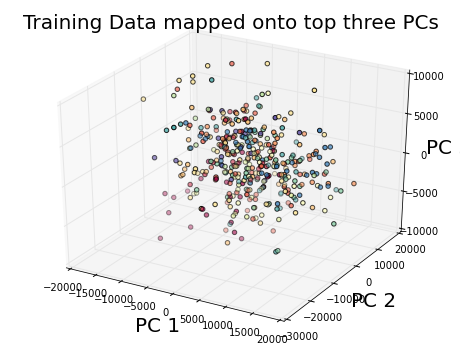

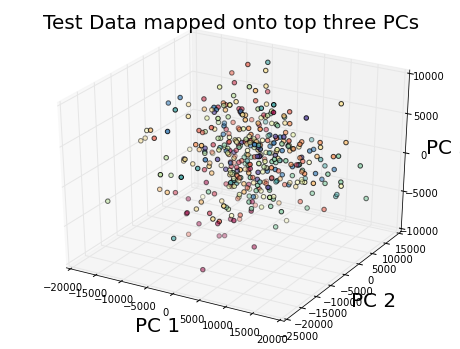

In [15]:
# Sanity check to see how the PCA is doing

# plot

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.cm as cm
%matplotlib inline



fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sample_size = 400

rand_seed = 123
np.random.seed(rand_seed)
random_indices = np.random.choice(len(new_X_train), size=sample_size, replace=False)

xs = new_X_train[random_indices, 0]
ys = new_X_train[random_indices, 1]
zs = new_X_train[random_indices, 2]
labels = (y_train[random_indices]).flatten()

label_set = set(list(labels))



ax.scatter(xs=xs, ys=ys, zs=zs, c=labels, cmap=cm.Spectral)
ax.set_xlabel("PC 1", fontsize=20)
ax.set_ylabel("PC 2", fontsize=20)
ax.set_zlabel("PC 3", fontsize=20)
ax.set_xlim(-20000, 20000)
ax.set_zlim(-10000, 10000)
plt.legend(loc='best')
plt.title("Training Data mapped onto top three PCs", fontsize=20)
plt.show()

# plax.scatter(xs=xs, ys=ys, zs=zs, c=labels, cmap=cm.Spectral)



rand_seed = 123
np.random.seed(rand_seed)
random_indices = np.random.choice(len(new_X_test), size=sample_size, replace=False)

xs = new_X_test[random_indices, 0]
ys = new_X_test[random_indices, 1]
zs = new_X_test[random_indices, 2]
labels = (y_test[random_indices]).flatten()


fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=xs, ys=ys, zs=zs, c=labels, cmap=cm.Spectral)
ax.set_xlabel("PC 1", fontsize=20)
ax.set_ylabel("PC 2", fontsize=20)
ax.set_zlabel("PC 3", fontsize=20)
ax.set_xlim(-20000, 20000)
ax.set_zlim(-10000, 10000)
plt.legend(loc='best')
plt.title("Test Data mapped onto top three PCs", fontsize=20)
plt.show()

# check inverse transform


# Plot the PCs with violinplots, baby

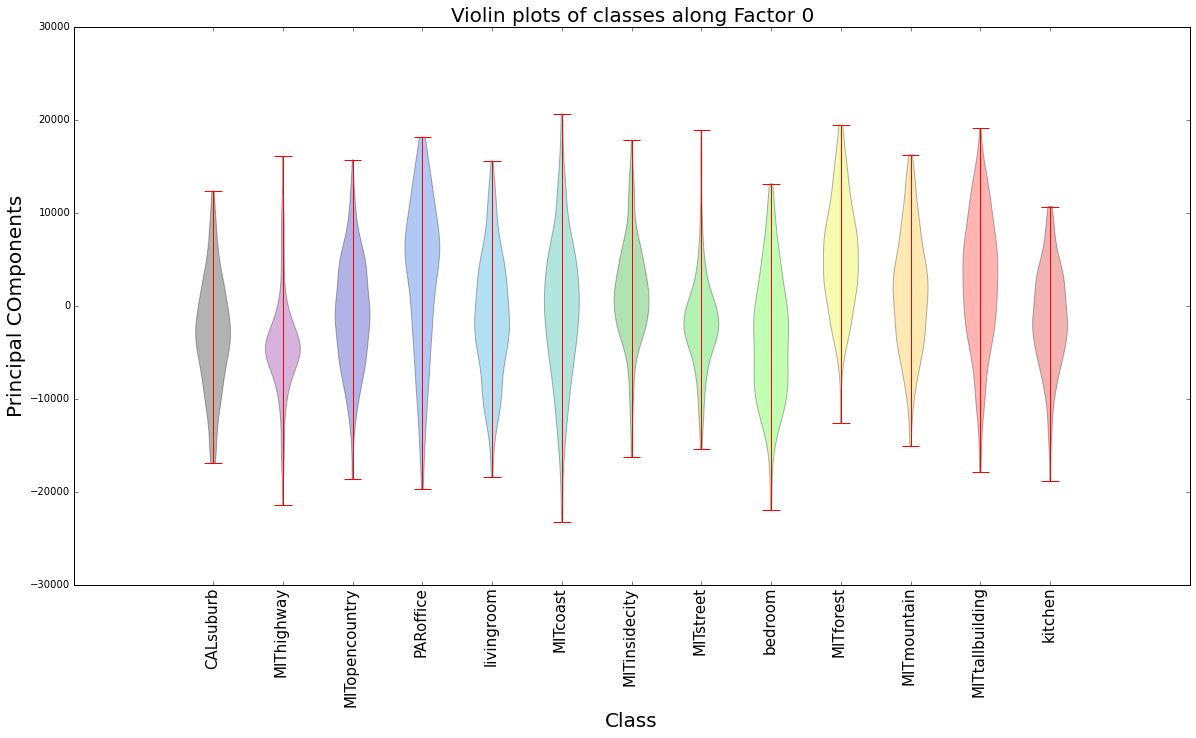

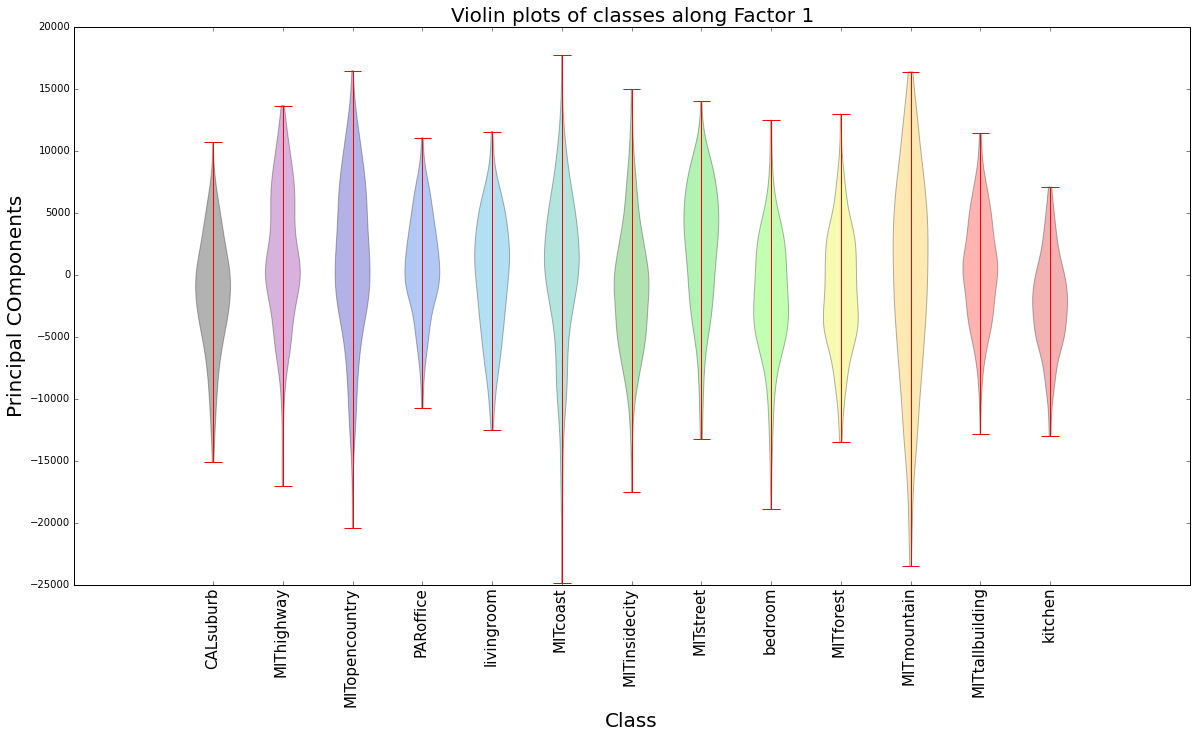

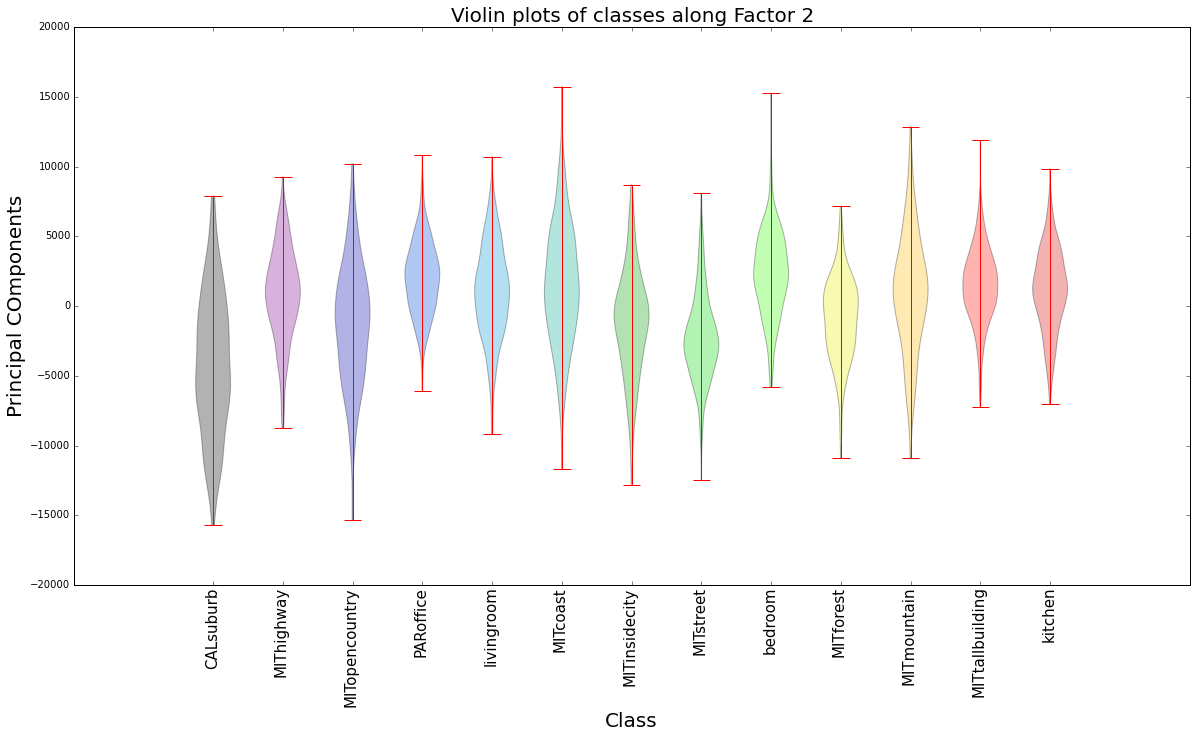

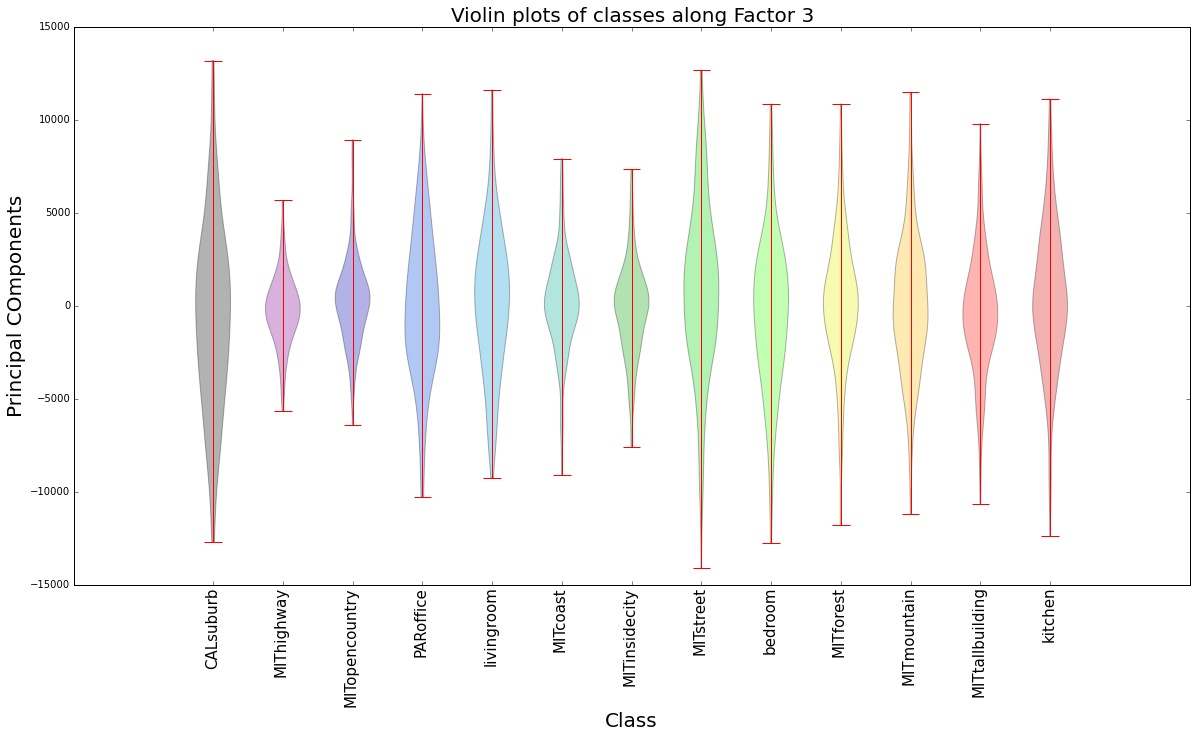

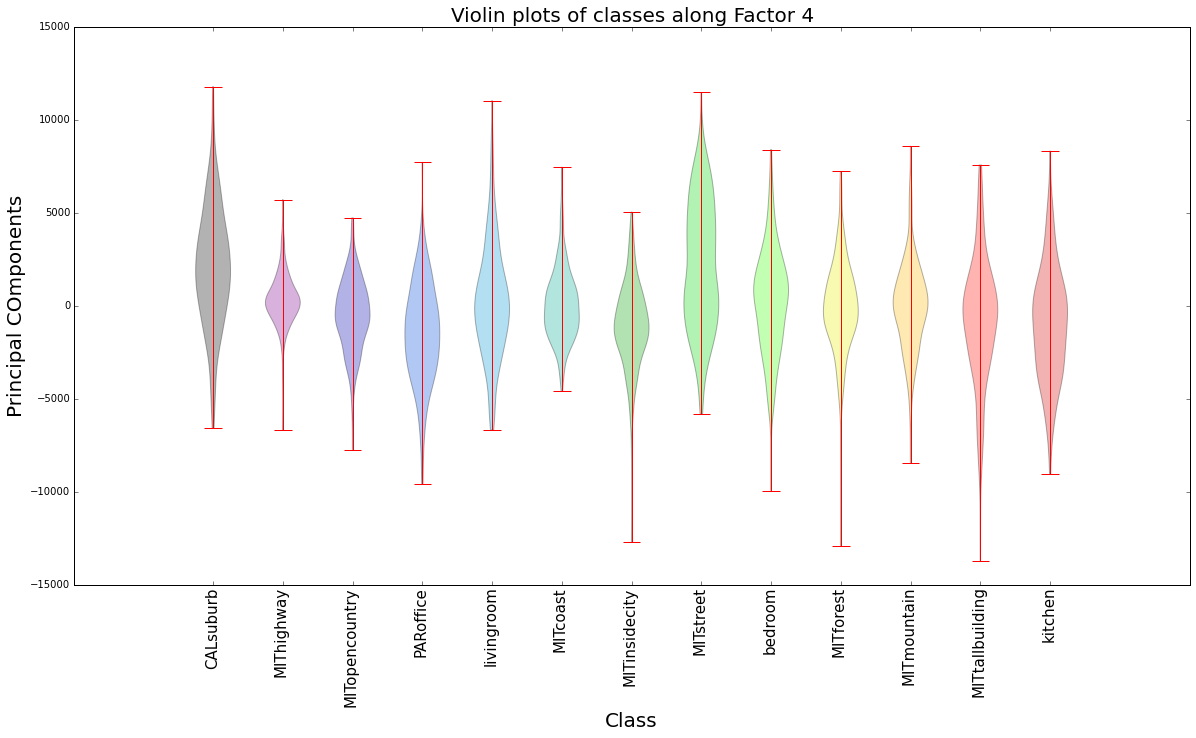

In [19]:
labels = range(13)
num_factors = 5 # You can change this is you'd like
new_X = np.concatenate((new_X_train, new_X_test))
y = np.concatenate((y_train, y_test))

new_X_seg = [[new_X[np.where(y.flatten() == i)[0], k] for i in range(13)] for k in range(num_factors)]
for k in range(num_factors):
    plt.figure(figsize=(20,10))
    violin_parts = plt.violinplot(new_X_seg[k], positions=labels)
    for i in range(len(violin_parts['bodies'])):
        pc = violin_parts['bodies'][i]
        pc.set_facecolor(cm.spectral(i * 1.0 / len(labels)))

    plt.xlabel("Class", fontsize=20)
    plt.ylabel("Principal COmponents",fontsize=20)
    plt.title("Violin plots of classes along Factor " + str(k), fontsize=20)
    plt.xticks(labels, classes, rotation='vertical', fontsize=15)
plt.show()

# Do NMF over train, save train, and test, and model

# MAKE SURE THAT YOUR VALUES ARE NONNEGATIVE HERE

### In the below, check the reconstruction error. You probably don't have to do all the tolearnces or components, unless the smallest factors are straight horrible. i.e. KILL IF YOU NEED TO.

### The tolerances ("tols") control how long it'll take  to converge
### As long as the feature reconstruction error is pretty small (what that means depends on the average magnitude of the features that you're putting in

In [ ]:
from sklearn.decomposition import NMF, TruncatedSVD
import csv
import pickle
import os

comp_list = [5, 10, 20, 50, 100, 500]
tols = [20.0, 1.0, 0.01, 1e-3, 1e-4]
random_state = 123

for tol in tols:
    for comp in comp_list:
        nmf = NMF(n_components=comp, random_state=random_state, tol=tol)
        print "Fitting nmf..."
        %time nmf.fit(X_train)
        print "Transforming nmf..."
        %time new_X_train= nmf.transform(X_train)
        %time new_X_test = nmf.transform(X_test)

        feature_name = base_feature + "-nmf-" + str(comp) +'-tol' + str(tol)
        out_train_file_name = "features/X_train-" + feature_name
        out_test_file_name = "features/X_test-" + feature_name
        out_model_file_name = "features/model-" + feature_name + '.p'
        out_model_component_file_name = "features/model-components-" + feature_name
        out_model_error_file_name = "features/model-error-" + feature_name

        np.save(out_train_file_name, new_X_train)
        np.save(out_test_file_name, new_X_test)
        pickle.dump(nmf, open(out_model_file_name, 'wb'))
        components = nmf.components_
        np.save(out_model_component_file_name,components)
        err = np.array(nmf.reconstruction_err_)
        np.save(out_model_error_file_name, err)




        print "Training saved to ", out_train_file_name + ".npy"
        print "Test saved to ", out_test_file_name + ".npy"
        print "Model saved to ", out_model_file_name
        print "Model components saved to ", out_model_component_file_name + ".npy"
        print "Error saved to ", out_model_error_file_name + ".npy"    

        print "For comp, ", comp, "VREconstruction error e explained is ",err
        print "Average error per image ", err/len(X_train)
        print "Average error per image feature ",  err/(len(X_train) * len(X_train[0]))


        os.system("say 'finished writing nmf'")
    # Save variance


Fitting nmf...
CPU times: user 11.8 s, sys: 28.6 s, total: 40.3 s
Wall time: 2min 24s
Transforming nmf...
CPU times: user 23.4 s, sys: 6.94 s, total: 30.3 s
Wall time: 37.6 s
CPU times: user 6.26 s, sys: 1.51 s, total: 7.78 s
Wall time: 11 s
Training saved to  features/X_train-greyscale-nmf-5-tol20.0.npy
Test saved to  features/X_test-greyscale-nmf-5-tol20.0.npy
Model saved to  features/model-greyscale-nmf-5-tol20.0.p
Model components saved to  features/model-components-greyscale-nmf-5-tol20.0.npy
Error saved to  features/model-error-greyscale-nmf-5-tol20.0.npy
For comp,  5 VREconstruction error e explained is  777417.855914
Average error per image  252.162781678
Average error per image feature  0.00379648873349
Fitting nmf...
CPU times: user 11.6 s, sys: 22.5 s, total: 34.1 s
Wall time: 2min 13s
Transforming nmf...
CPU times: user 55.5 s, sys: 8.41 s, total: 1min 3s
Wall time: 1min 11s
CPU times: user 13.9 s, sys: 2.28 s, total: 16.2 s
Wall time: 18.9 s
Training saved to  features/X_t

## Plot NMF

### You may  need to change the names below to the correct name of the nmf files that were written

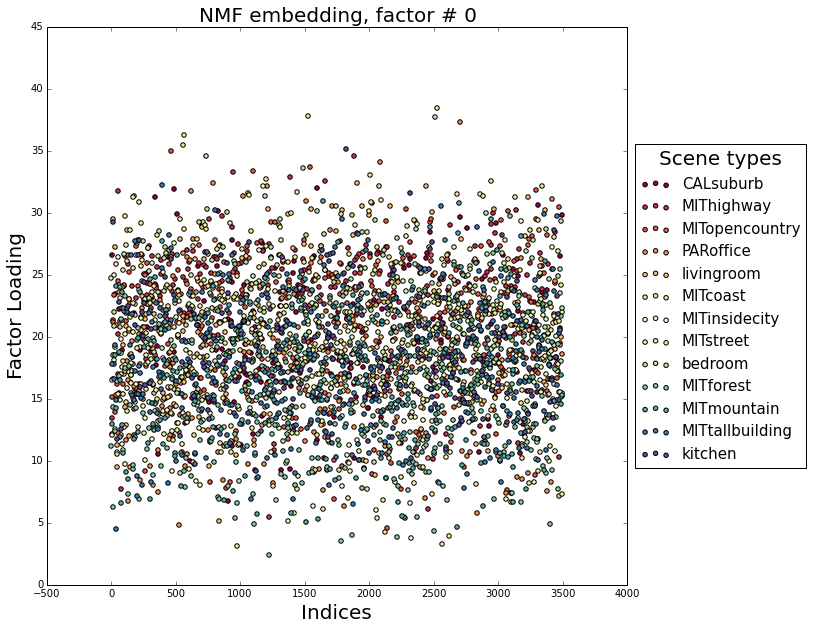

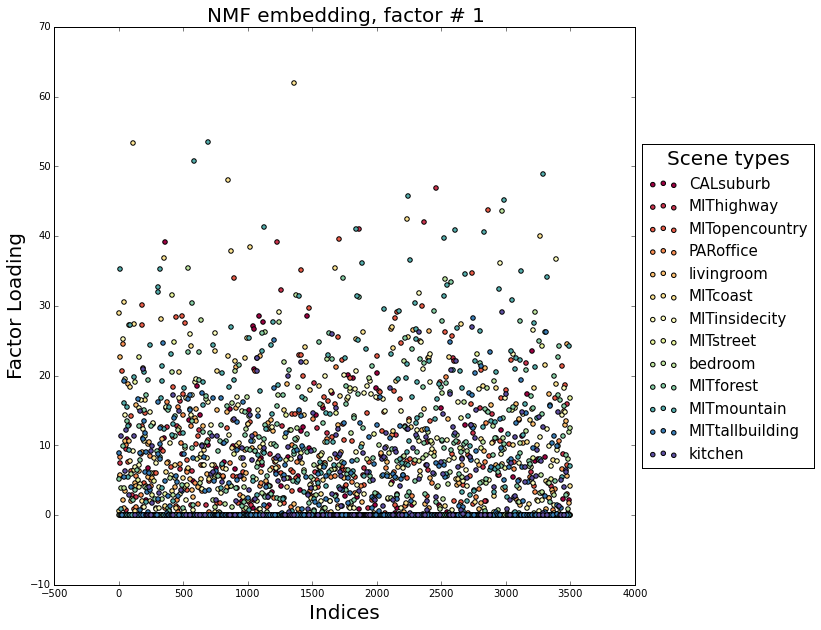

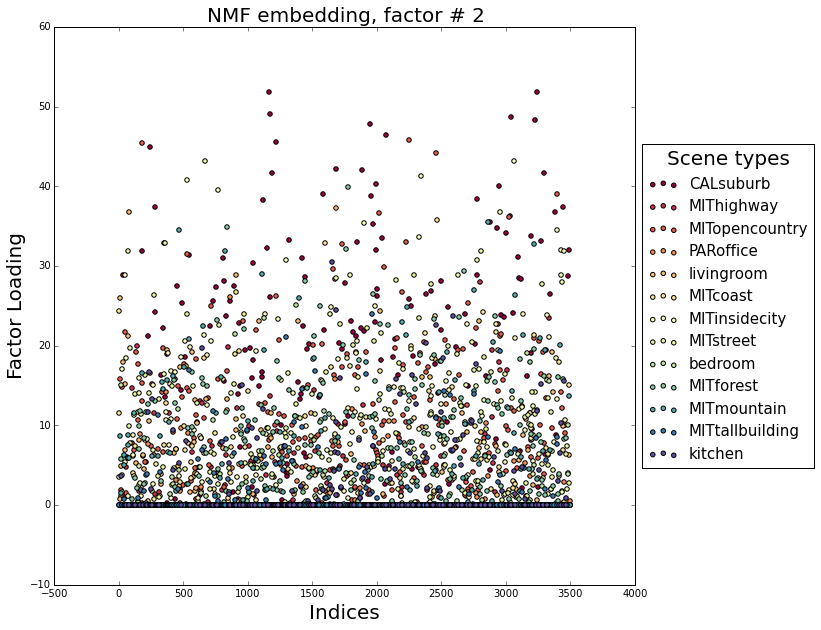

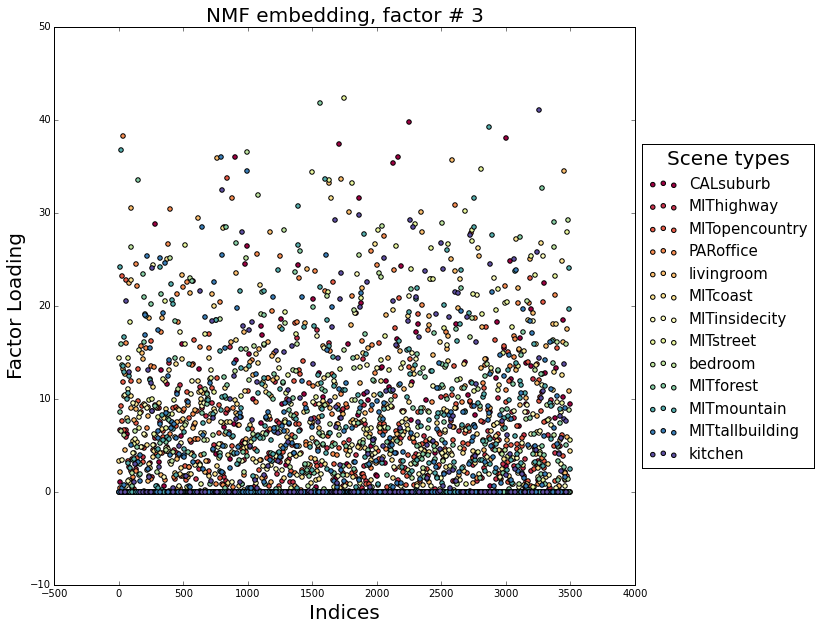

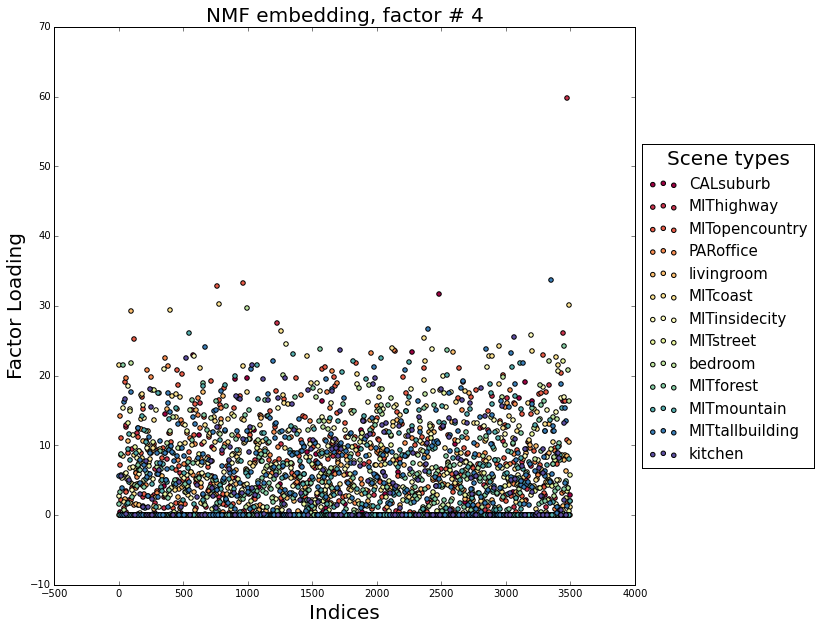

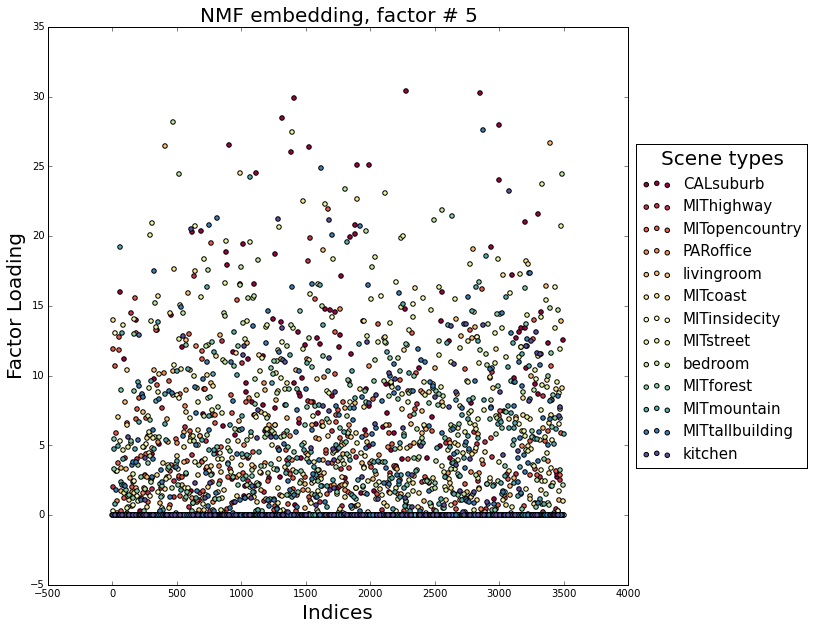

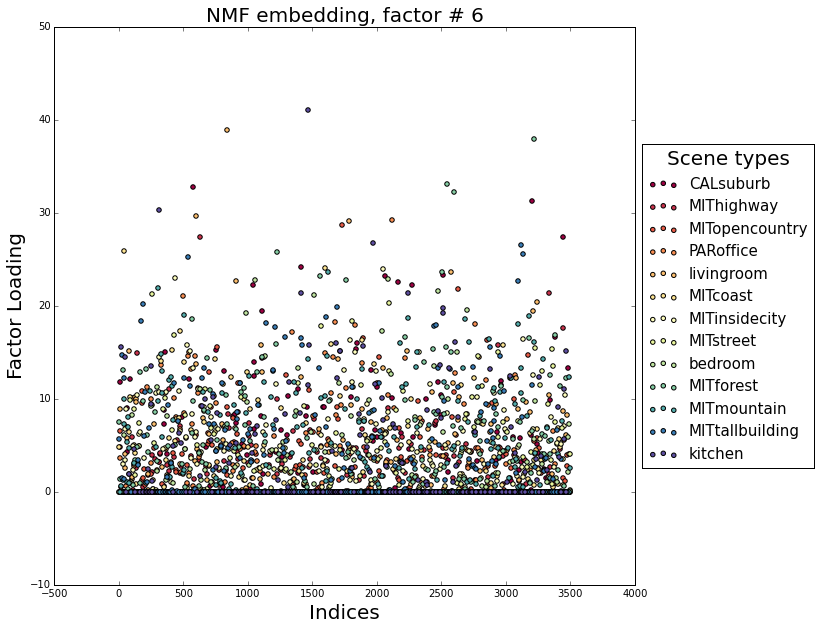

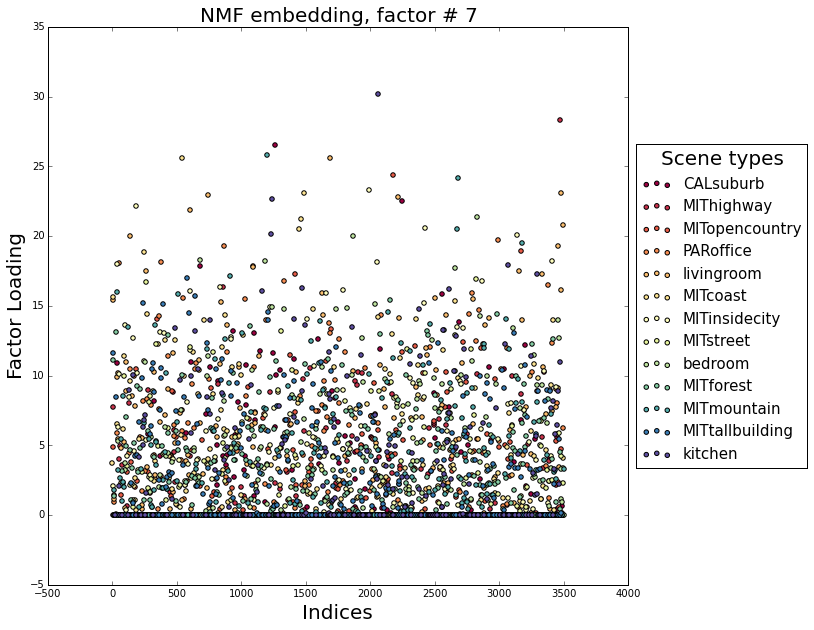

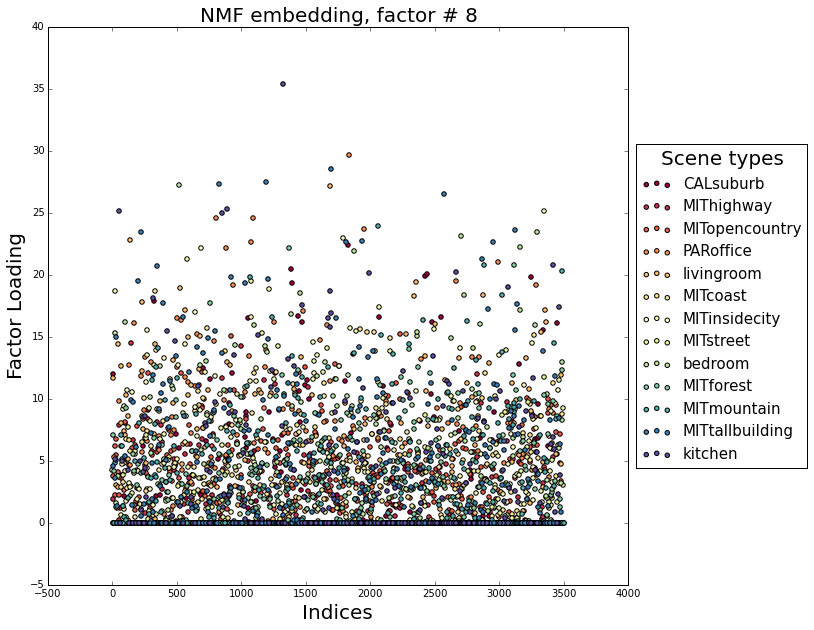

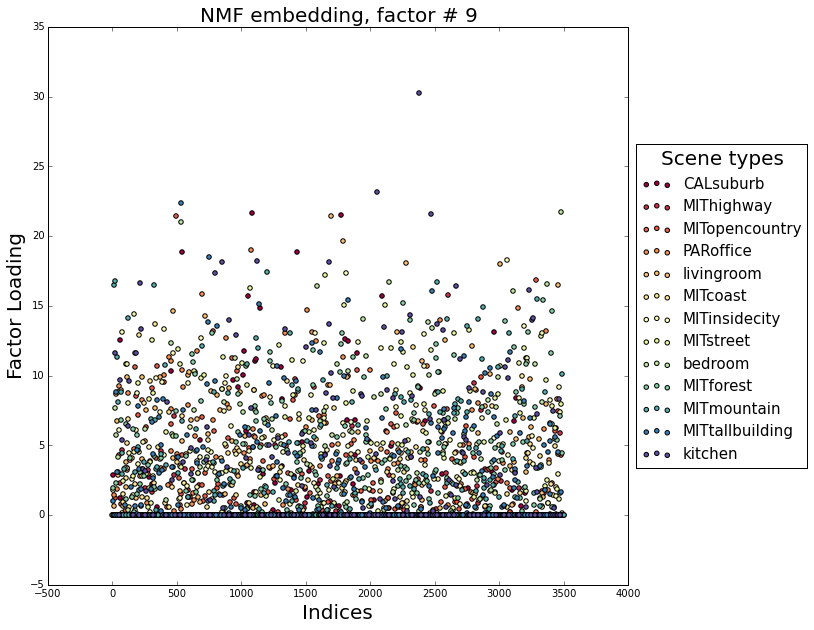

In [61]:
import matplotlib.pyplot as plt
%matplotlib inline
# Auto-loads the previous values.
new_X_train = np.load("features/X_train-" + base_feature "-nmf-10-tol20.0.npy")
new_X_test = np.load("features/X_test-" + base_feature "-nmf-10-tol20.0.npy")
new_X = np.concatenate((new_X_train, new_X_test))

y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)
y = np.concatenate((y_train, y_test))





np.random.seed(random_state)
random_indices = np.random.choice(len(new_X), size=3500, replace=False)
new_X_sample = new_X[random_indices]
y_sample = y[random_indices]

num_factors = len(new_X_train[0])



for k in range(num_factors):
    fig = plt.figure(figsize=(13,10))
    ax = plt.subplot(111)
    for i in range(13):
        indices = np.where(y_sample == i)[0]
        ax.scatter(indices, new_X_sample[indices,k], c=colors[i], label=classes[i])
    plt.title("NMF embedding, factor # " + str(k), fontsize=20)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Scene types', fontsize=15)

    plt.xlabel("Indices", fontsize=20)
    plt.ylabel("Factor Loading", fontsize=20)
    plt.setp(leg.get_title(),fontsize=20)
    plt.show()



# Make some violin plots for NMF. Will plot for all the factors!
# Look for factors where some classes are a lot different from others.

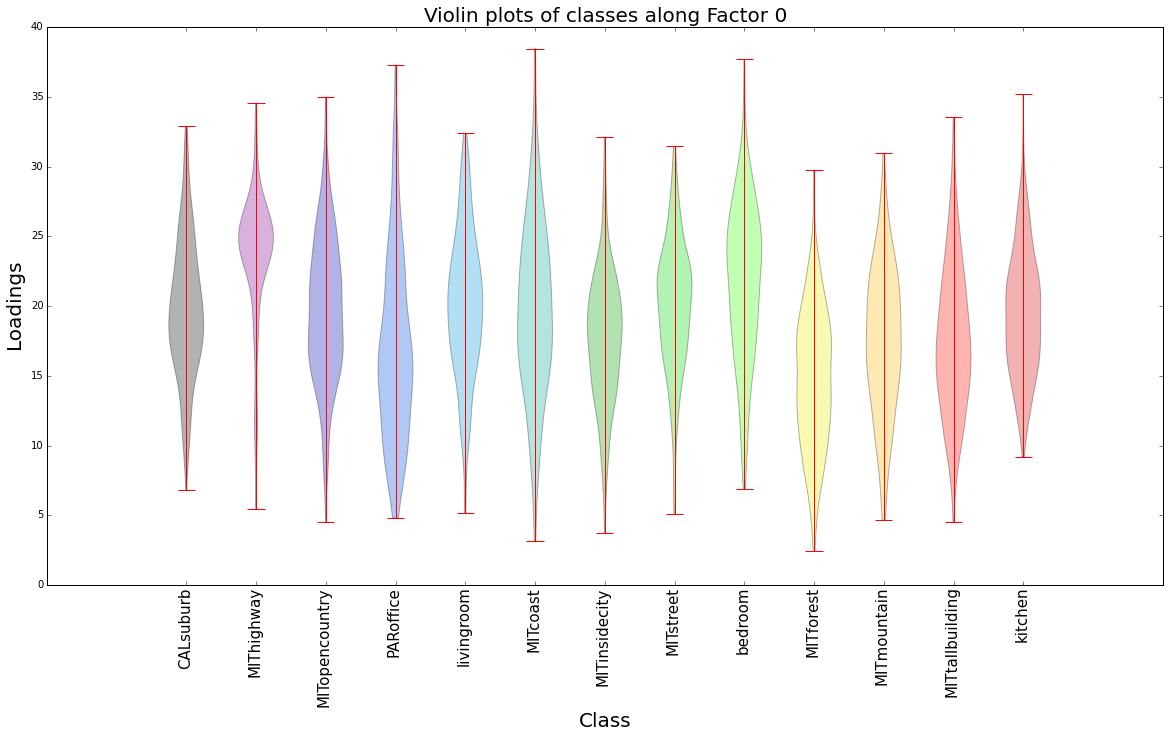

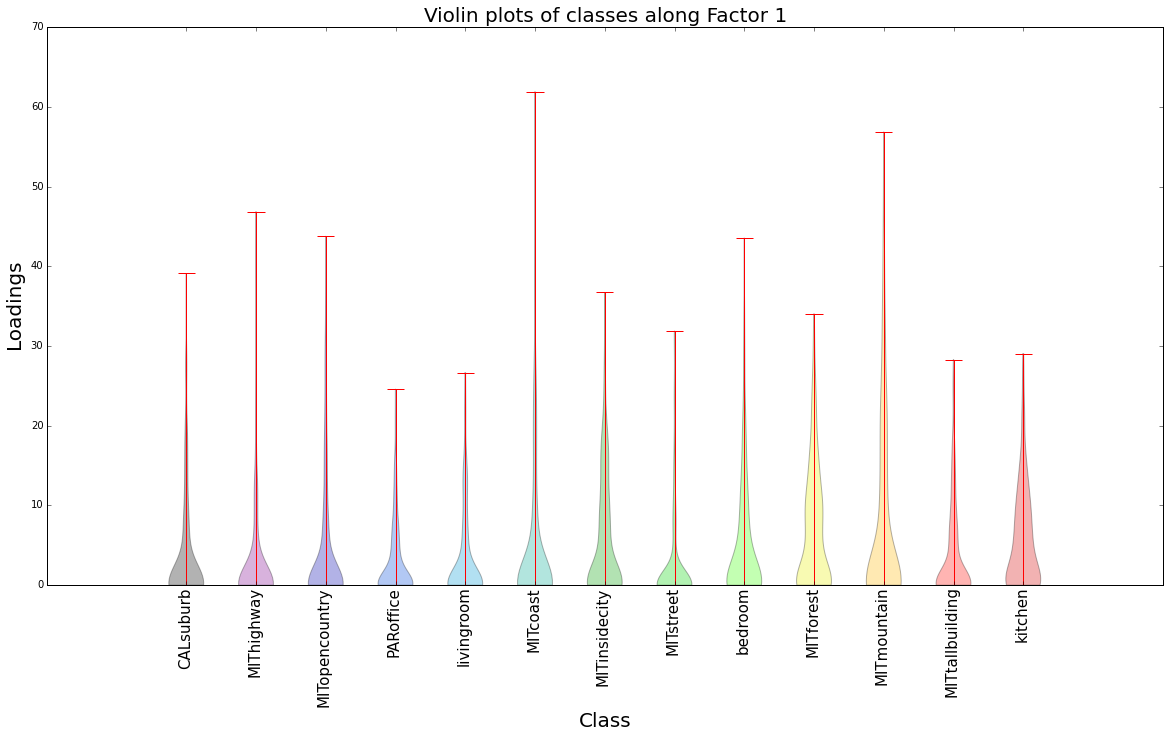

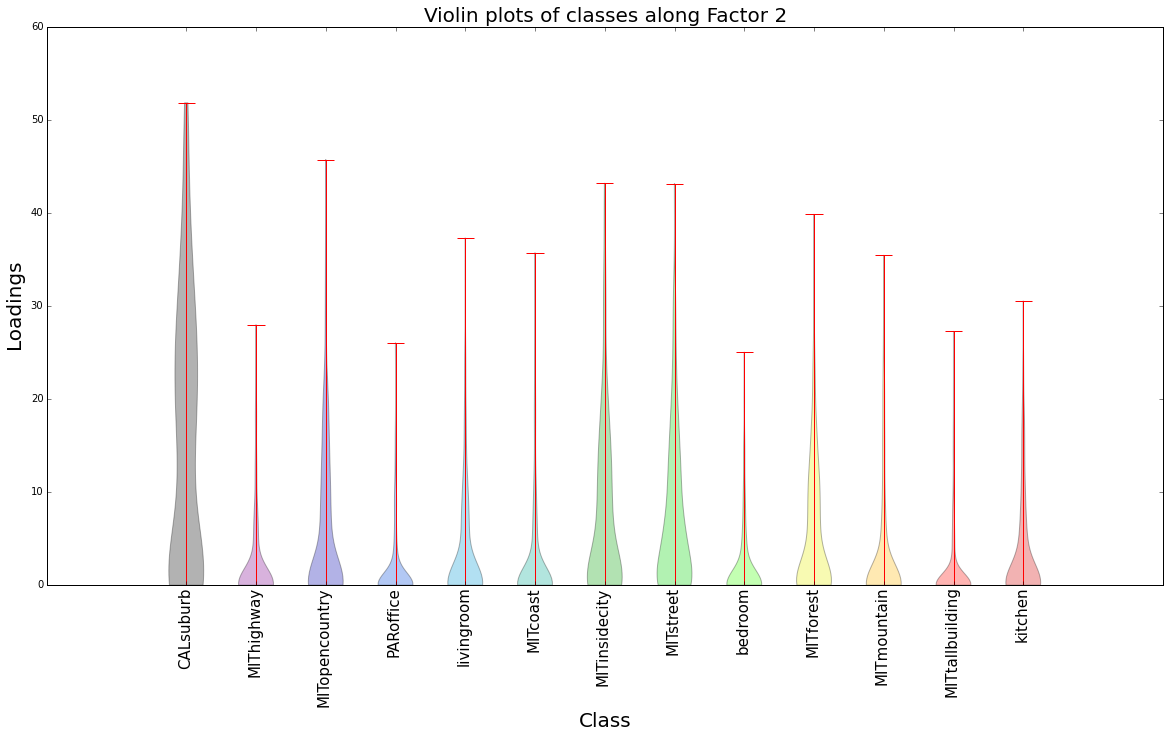

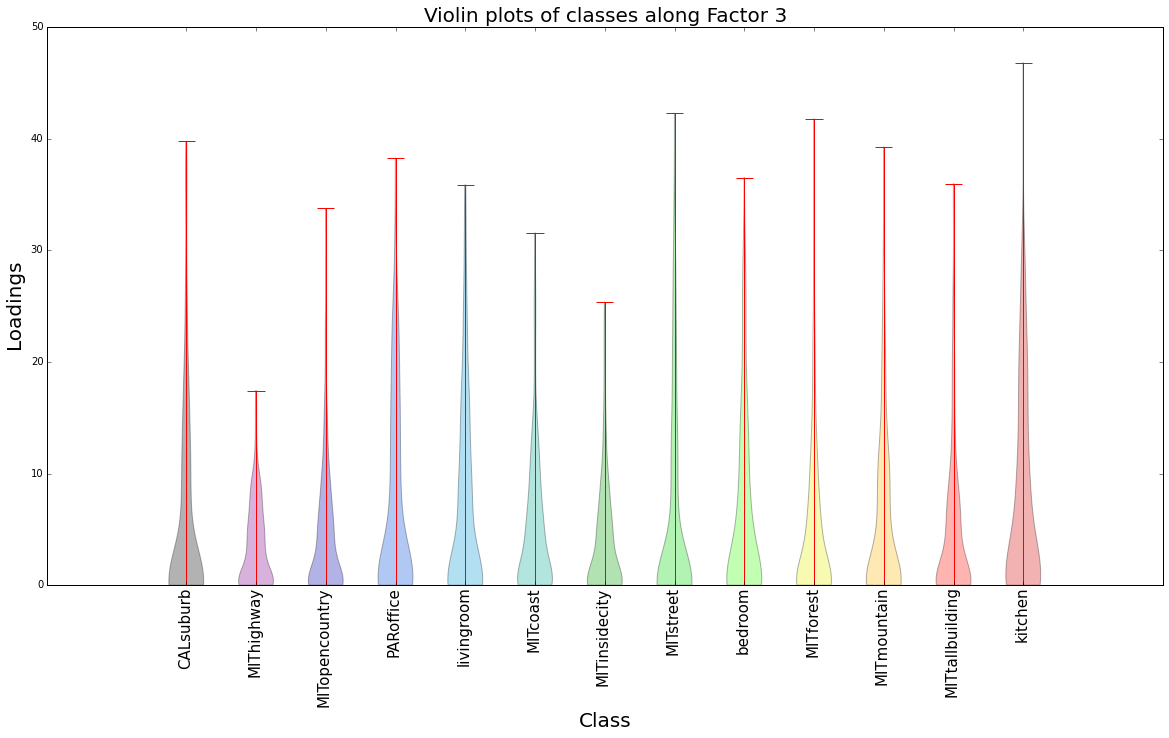

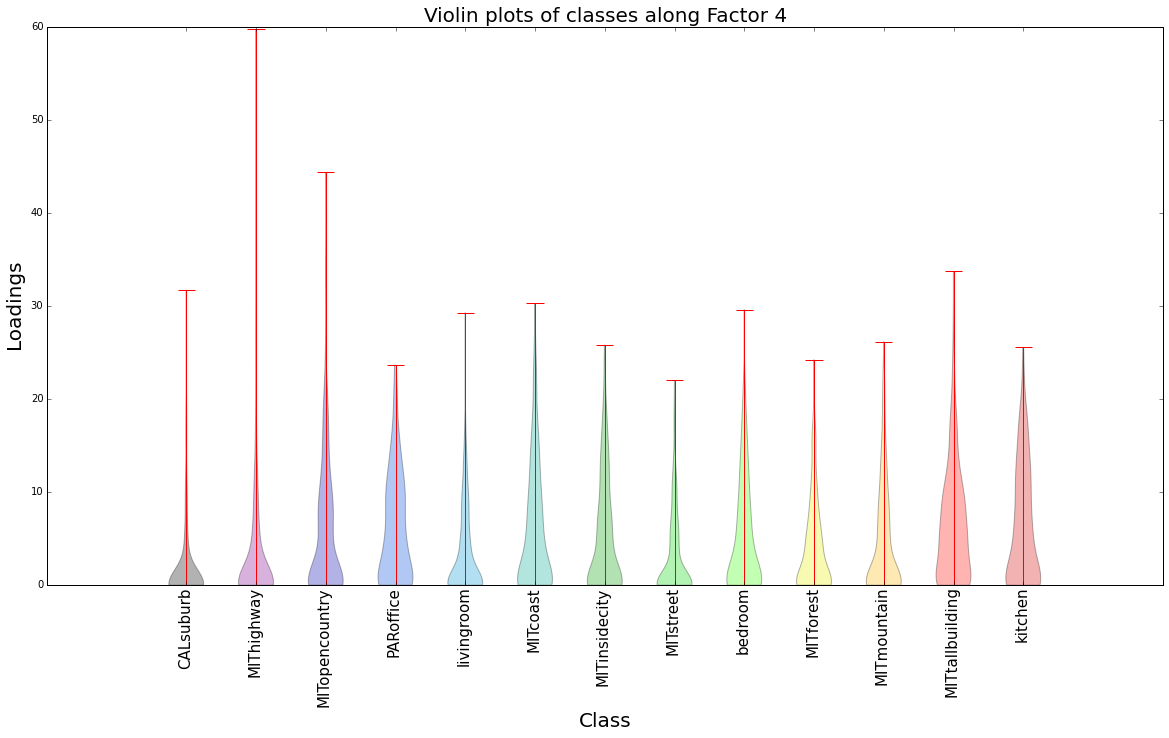

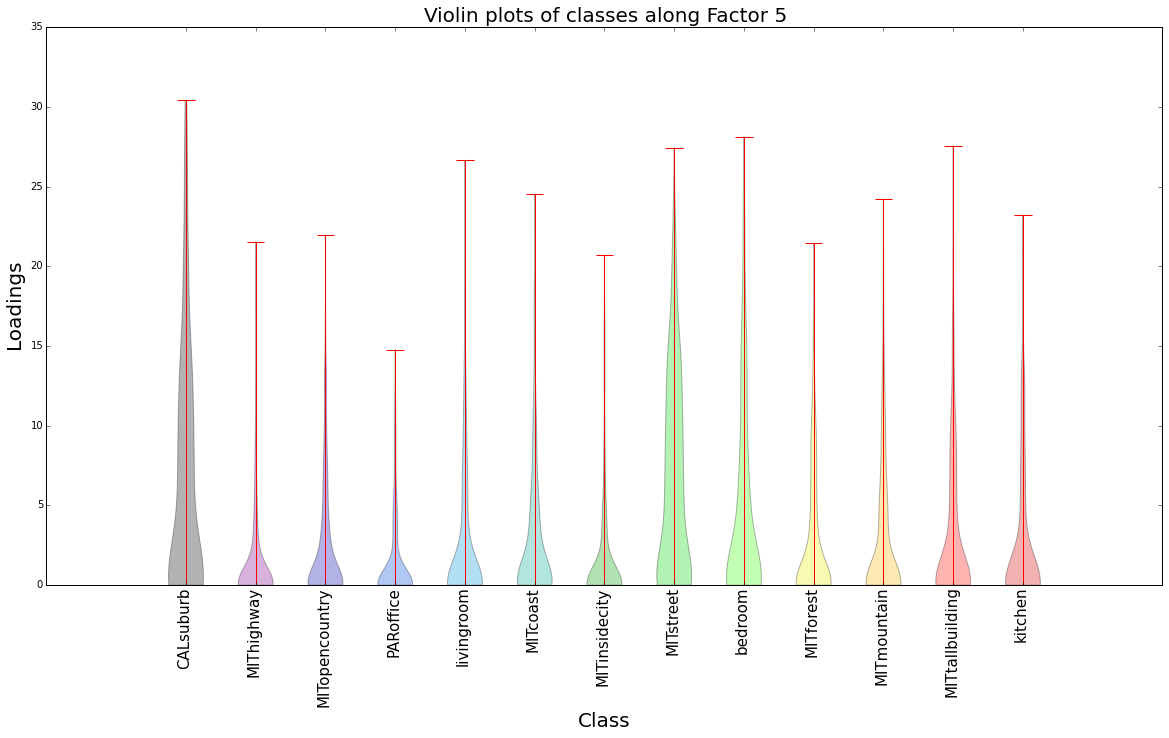

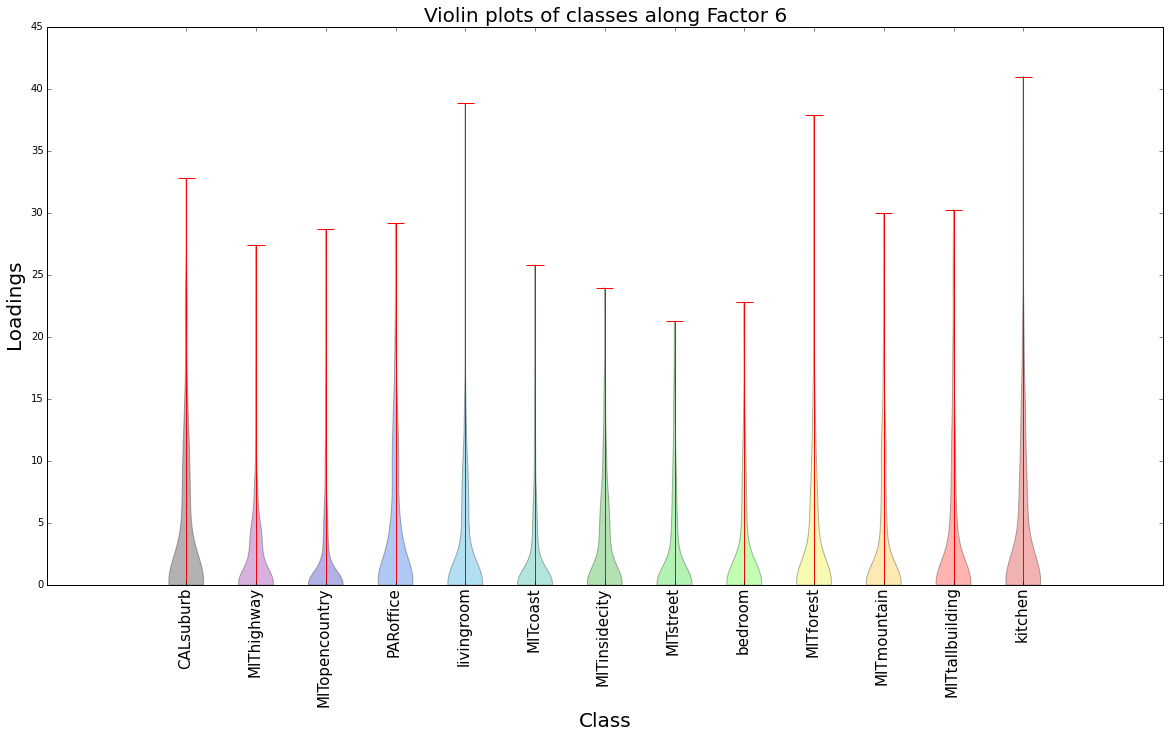

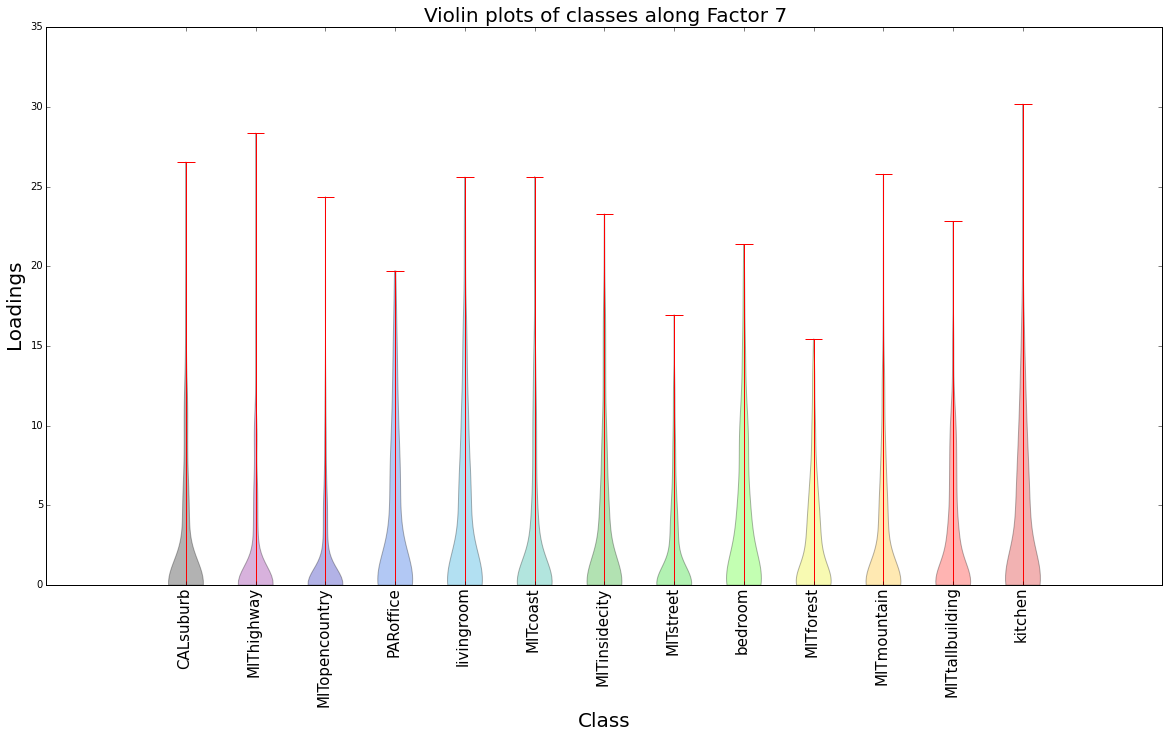

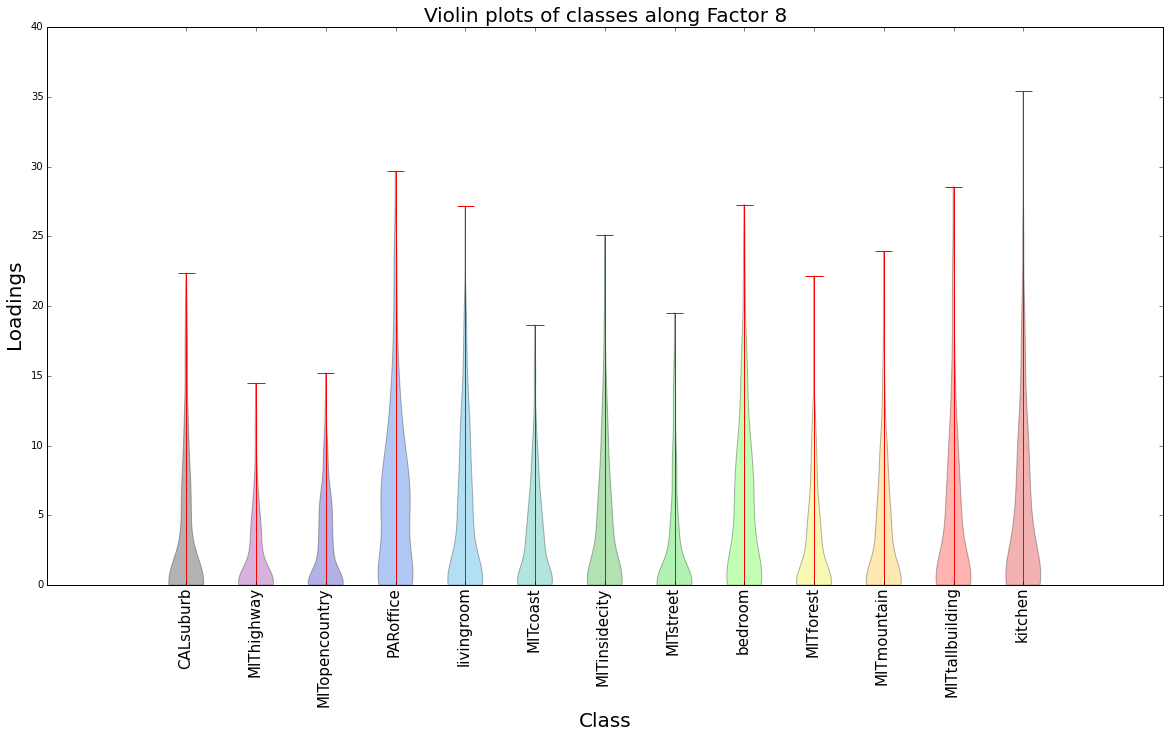

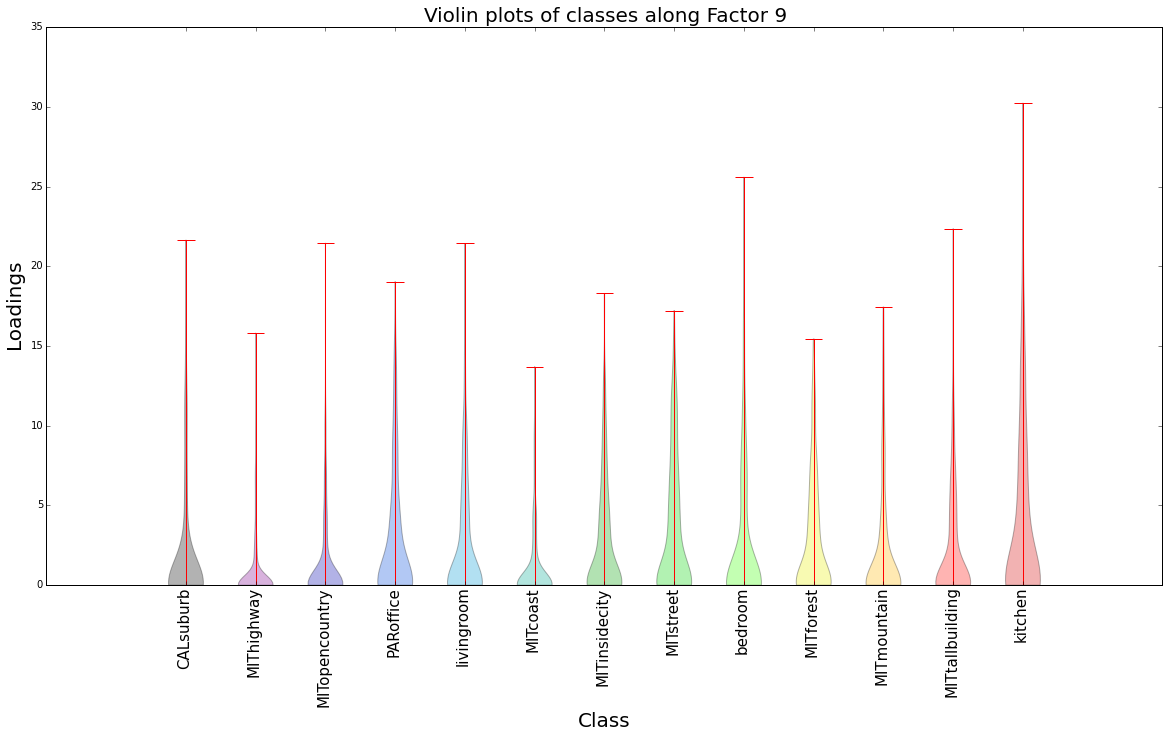

In [80]:
labels = range(13)
num_factors = len(new_X[0])
new_X_seg = [[new_X[np.where(y.flatten() == i)[0], k] for i in range(13)] for k in range(num_factors)]
for k in range(num_factors):
    plt.figure(figsize=(20,10))
    violin_parts = plt.violinplot(new_X_seg[k], positions=labels)
    for i in range(len(violin_parts['bodies'])):
        pc = violin_parts['bodies'][i]
        pc.set_facecolor(cm.spectral(i * 1.0 / len(labels)))

    plt.xlabel("Class", fontsize=20)
    plt.ylabel("Loadings",fontsize=20)
    plt.title("Violin plots of classes along Factor " + str(k), fontsize=20)
    plt.xticks(labels, classes, rotation='vertical', fontsize=15)
plt.show()

# Do isomap over train, save train, and test, and model

# You MIGHT run out of memory for running all the neighbors. If so, just see if you can run with neigh_list=[5]. If you don't run out of memory, try all of them and see which has the best (least) reconstruction error.

In [7]:
from sklearn.manifold import Isomap
import csv
import pickle
import os


random_state = 123
comp_list = [2]
neigh_list = [5, 10, 50]
# neigh_list = [10, 50]
for neigh in neigh_list:
    for comp in comp_list:
        iso = Isomap(n_components=comp, n_neighbors = neigh, tol=0.00001)
        print "Fitting iso..."
        %time iso.fit(X_train)
        print "Transforming iso..."
        %time new_X_train= iso.transform(X_train)
        %time new_X_test = iso.transform(X_test)

        feature_name = base_feature + "-iso-" + str(comp) +'-'+ str(neigh) + '-'
        out_train_file_name = "features/X_train-" + feature_name
        out_test_file_name = "features/X_test-" + feature_name
        out_model_file_name = "features/model-" + feature_name + '.p'
        out_model_component_file_name = "features/model-components-" + feature_name
        out_model_error_file_name = "features/model-error-" + feature_name

        np.save(out_train_file_name, new_X_train)
        np.save(out_test_file_name, new_X_test)
        pickle.dump(iso, open(out_model_file_name, 'wb'))
        embedding = iso.embedding_
        np.save(out_model_component_file_name,embedding)        
        err = np.array(iso.reconstruction_error())
        np.save(out_model_error_file_name, err)

        print "Training saved to ", out_train_file_name + ".npy"
        print "Test saved to ", out_test_file_name + ".npy"
        print "Model saved to ", out_model_file_name
        print "Model components saved to ", out_model_component_file_name + ".npy"
        print "Error saved to ", out_model_error_file_name + ".npy"    

        print "For neighbors, ", neigh, "For comp, ", comp, "VREconstruction error e explained is ",err
        print "Average error per image ", err/len(X_train)
        print "Average error per image pixel ",  err/(len(X_train) * len(X_train[0]))


        os.system("say 'finished writing iso'")



Fitting iso...
CPU times: user 16.6 s, sys: 230 ms, total: 16.8 s
Wall time: 17.6 s
Transforming iso...
CPU times: user 9.05 s, sys: 162 ms, total: 9.21 s
Wall time: 9.93 s
CPU times: user 2.05 s, sys: 26.7 ms, total: 2.08 s
Wall time: 2.09 s
Training saved to  features/X_train-greyscale-iso-2-5-.npy
Test saved to  features/X_test-greyscale-iso-2-5-.npy
Model saved to  features/model-greyscale-iso-2-5-.p
Model components saved to  features/model-components-greyscale-iso-2-5-.npy
Error saved to  features/model-error-greyscale-iso-2-5-.npy
For neighbors,  5
For comp,  2 VREconstruction error e explained is  137515128.421
Average error per image  44604.3231985
Average error per image pixel  89.2086463971
Fitting iso...
CPU times: user 16.9 s, sys: 86.7 ms, total: 16.9 s
Wall time: 16.9 s
Transforming iso...
CPU times: user 8.51 s, sys: 57.3 ms, total: 8.56 s
Wall time: 8.55 s
CPU times: user 2.11 s, sys: 27.7 ms, total: 2.14 s
Wall time: 2.16 s
Training saved to  features/X_train-greyscal

## Plot Isomap

### You may  need to change the names below to the correct name of the iso files that were written

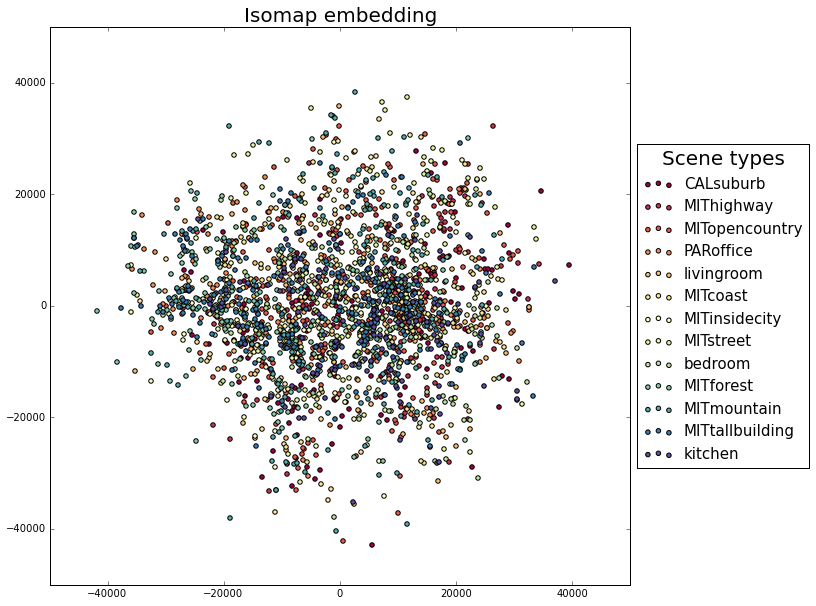

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
new_X_train = np.load("features/X_train-" + base_feature + "-iso-2-5-.npy")
new_X_text = np.load("features/X_test-" + base_feature + "-iso-2-5-.npy")
new_X = np.concatenate((new_X_train, new_X_test))

y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)
y = np.concatenate((y_train, y_test))


fig = plt.figure(figsize=(13,10))
ax = plt.subplot(111)


np.random.seed(random_state)
random_indices = np.random.choice(len(new_X), size=2500, replace=False)
new_X_sample = new_X[random_indices]
y_sample = y[random_indices]

for i in range(13):
    indices = np.where(y_sample == i)[0]
    ax.scatter(new_X_sample[indices,0], new_X_sample[indices,1], c=colors[i], label=classes[i])
plt.title("Isomap embedding", fontsize=20)

box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Scene types', fontsize=15)

plt.setp(leg.get_title(),fontsize=20)
plt.show()


# Run with t-SNE dimensionality reduction
### This loads the PCA file that you ran, so you should first change the names below
### It will automatically plot below :)
# To choose the right one, find the one that seperates the data far from each other the most

In [17]:
base_feature = "greyscale" # ignore this
PCA_TRAIN_FILE_NAME = 'features/X_train-' + base_feature + '-pca-500-.npy'
PCA_TEST_FILE_NAME = 'features/X_test-' + base_feature + '-pca-500-.npy'

Fitting tsne...
CPU times: user 5min 40s, sys: 45.4 s, total: 6min 25s
Wall time: 6min 31s
Training saved to  features/X_train-greyscale-tsne-2learning-rate100.0afterloadingpca.npy
Test saved to  features/X_test-greyscale-tsne-2learning-rate100.0afterloadingpca.npy
Model saved to  features/model-greyscale-tsne-2learning-rate100.0afterloadingpca.p
Model components saved to  features/model-components-greyscale-tsne-2learning-rate100.0afterloadingpca.npy


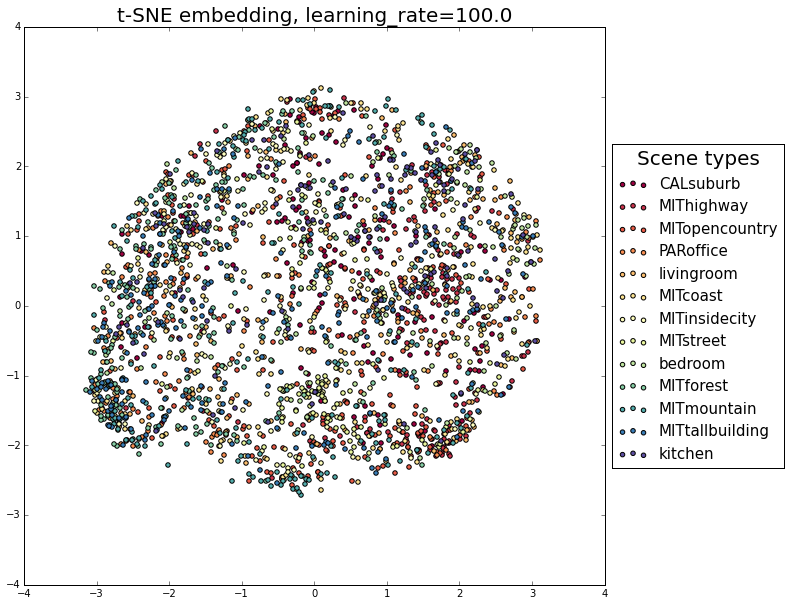

Fitting tsne...


KeyboardInterrupt: 

In [19]:
# Load the sample pca you have
# Run with X and y
# It is perfectly fine to run t-SNE ten times, and select the solution with the lowest KL divergence.
# one could say that a larger / denser dataset requires a larger perplexity. Typical values for the perplexity range between 5 and 50.
#  In t-SNE, the perplexity may be viewed as a knob that sets the number of effective nearest neighbors. It is comparable with the number of nearest neighbors k that is employed in many manifold learners.
#  increase the degrees of freedom of the t-distribution when embedding into thirty dimensions (or if you try to embed intrinsically very low-dimensional data such as the Swiss roll). 


from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
%matplotlib inline


y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)

pca_X_train = np.load(PCA_TRAIN_FILE_NAME)
pca_X_test = np.load(PCA_TEST_FILE_NAME)
pca_X = np.concatenate((pca_X_train, pca_X_test))
num_X_train = len(pca_X_train)
y = np.concatenate((y_train, y_test))

# random_indices = np.random.choice(len(pca_X), size=2500, replace=False)
# pca_X = pca_X[random_indices]
# y = y[random_indices]


num_rand = 1
init='random'
random_state = 123
learning_rates = np.linspace(100, 1000, 5)
comp_list = [2]
for learning_rate in learning_rates:
    for comp in comp_list:
            for i in range(num_rand):
                tsne = TSNE(n_components=comp, init=init, random_state=random_state, learning_rate=learning_rate)
                print "Fitting tsne..."
                %time new_X = tsne.fit_transform(pca_X)

                new_X_train = new_X[:num_X_train]
                new_X_test = new_X[num_X_train:]
                feature_name = base_feature + "-tsne-" + str(comp) + 'learning-rate' + str(learning_rate) + "afterloadingpca"
                out_train_file_name = "features/X_train-" + feature_name
                out_test_file_name = "features/X_test-" + feature_name
                out_model_file_name = "features/model-" + feature_name + '.p'
                out_model_component_file_name = "features/model-components-" + feature_name
                out_model_error_file_name = "features/model-error-" + feature_name

                np.save(out_train_file_name, new_X_train)
                np.save(out_test_file_name, new_X_test)
                pickle.dump(tsne, open(out_model_file_name, 'wb'))
                embeddings = tsne.embedding_
                np.save(out_model_component_file_name,embeddings)




                print "Training saved to ", out_train_file_name + ".npy"
                print "Test saved to ", out_test_file_name + ".npy"
                print "Model saved to ", out_model_file_name
                print "Model components saved to ", out_model_component_file_name + ".npy"
            
                os.system("say 'finished writing tsne'")
            
            
                fig = plt.figure(figsize=(13,10))
                ax = plt.subplot(111)
                
                
                np.random.seed(random_state)
                random_indices = np.random.choice(len(new_X), size=2500, replace=False)
                new_X_sample = new_X[random_indices]
                y_sample = y[random_indices]

                for i in range(13):
                    indices = np.where(y_sample == i)[0]
                    ax.scatter(new_X_sample[indices,0], new_X_sample[indices,1], c=colors[i], label=classes[i])
                plt.title("t-SNE embedding, learning_rate=" + str(learning_rate), fontsize=20)

                box = ax.get_position()
                ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                # Put a legend to the right of the current axis
                leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Scene types', fontsize=15)
                
                plt.setp(leg.get_title(),fontsize=20)
                plt.show()




# Run with Spectral Embedding dimensionality reduction
# To choose the right one, find the one that seperates the data far from each other the most (according to the plot)

Fitting spe...
CPU times: user 17.4 s, sys: 266 ms, total: 17.6 s
Wall time: 18.2 s
Training saved to  features/X_train-greyscale-spe-2-5-.npy
Test saved to  features/X_test-greyscale-spe-2-5-.npy
Model saved to  features/model-greyscale-spe-2-5-.p
Model components saved to  features/model-components-greyscale-spe-2-5-.npy


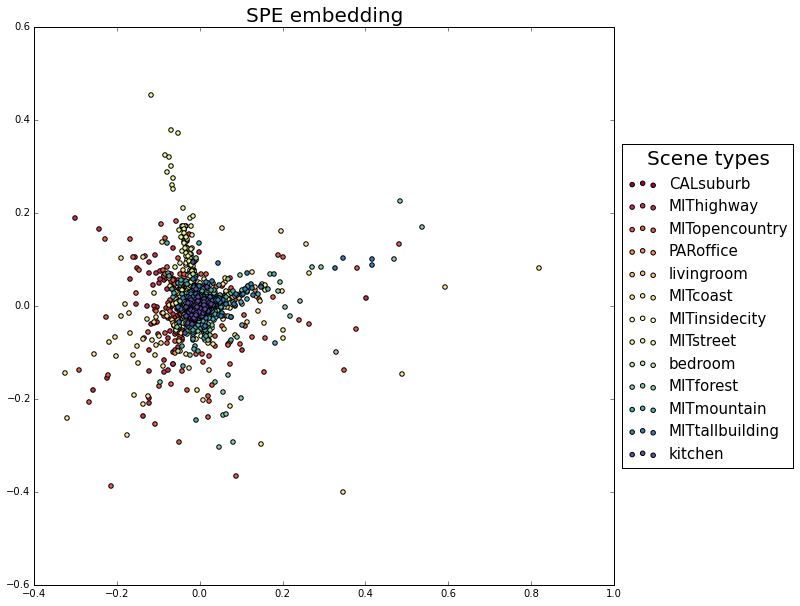

Fitting spe...
CPU times: user 18.7 s, sys: 261 ms, total: 19 s
Wall time: 18.9 s
Training saved to  features/X_train-greyscale-spe-2-10-.npy
Test saved to  features/X_test-greyscale-spe-2-10-.npy
Model saved to  features/model-greyscale-spe-2-10-.p
Model components saved to  features/model-components-greyscale-spe-2-10-.npy


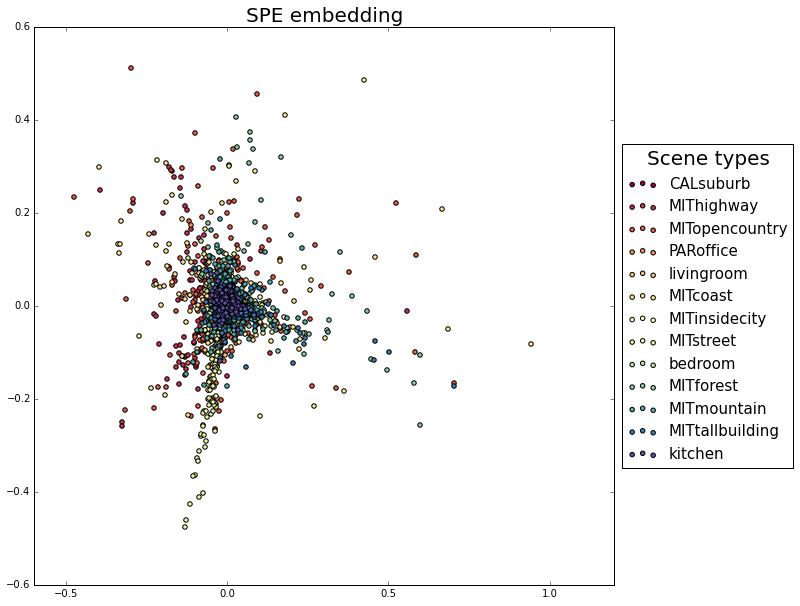

Fitting spe...
CPU times: user 23.9 s, sys: 263 ms, total: 24.1 s
Wall time: 24.5 s
Training saved to  features/X_train-greyscale-spe-2-50-.npy
Test saved to  features/X_test-greyscale-spe-2-50-.npy
Model saved to  features/model-greyscale-spe-2-50-.p
Model components saved to  features/model-components-greyscale-spe-2-50-.npy


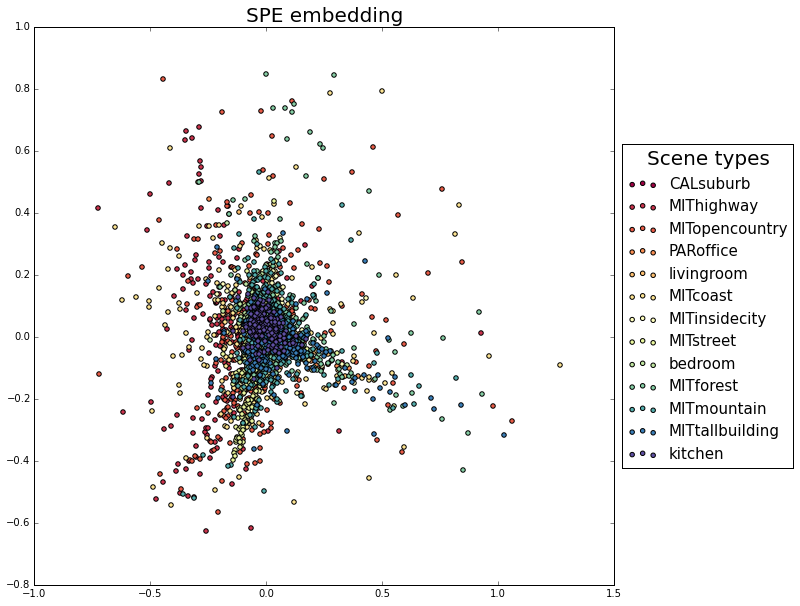

In [15]:
from sklearn.manifold import SpectralEmbedding
import csv
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)

X_train = np.load(X_train_filename)
X_test = np.load(X_test_filename)


X = np.concatenate((X_train, X_test))
num_X_train = len(X_train)

y = np.concatenate((y_train, y_test))


plot_sample_size = 3500 # You can change this if you'd like to control how much is plotted. But you probably don't need to



random_state = 123
comp_list = [2]
#neigh_list = [5, 10, 50]
neigh_list = [5, 10, 50]
for neigh in neigh_list:
    for comp in comp_list:
        spe = SpectralEmbedding(n_components=comp, n_neighbors = neigh)
        print "Fitting spe..."
        %time new_X = spe.fit_transform(X)
        new_X_train = new_X[:num_X_train]
        new_X_test = new_X[num_X_train:]

        feature_name = base_feature + "-spe-" + str(comp) +'-'+ str(neigh) + '-'
        out_train_file_name = "features/X_train-" + feature_name
        out_test_file_name = "features/X_test-" + feature_name
        out_model_file_name = "features/model-" + feature_name + '.p'
        out_model_component_file_name = "features/model-components-" + feature_name

        np.save(out_train_file_name, new_X_train)
        np.save(out_test_file_name, new_X_test)
        pickle.dump(spe, open(out_model_file_name, 'wb'))
        embedding = spe.embedding_
        np.save(out_model_component_file_name,embedding)        

        print "Training saved to ", out_train_file_name + ".npy"
        print "Test saved to ", out_test_file_name + ".npy"
        print "Model saved to ", out_model_file_name
        print "Model components saved to ", out_model_component_file_name + ".npy"


        os.system("say 'finished writing spe'")
        
        fig = plt.figure(figsize=(13,10))
        ax = plt.subplot(111)


        np.random.seed(random_state)
        random_indices = np.random.choice(len(new_X), size=plot_sample_size, replace=False)
        new_X_sample = new_X[random_indices]
        y_sample = y[random_indices]

        for i in range(13):
            indices = np.where(y_sample == i)[0]
            ax.scatter(new_X_sample[indices,0], new_X_sample[indices,1], c=colors[i], label=classes[i])
        plt.title("SPE embedding", fontsize=20)

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Scene types', fontsize=15)

        plt.setp(leg.get_title(),fontsize=20)
        plt.show()



# Run with MDS dimensionality reduction
# To choose the right one, find the one that seperates the data far from each other the most (according to the plot)

Fitting mds...
CPU times: user 1.49 s, sys: 198 ms, total: 1.69 s
Wall time: 1.6 s
Training saved to  features/X_train-greyscale-mds-2-5-.npy
Test saved to  features/X_test-greyscale-mds-2-5-.npy
Model saved to  features/model-greyscale-mds-2-5-.p
Model components saved to  features/model-components-greyscale-mds-2-5-.npy


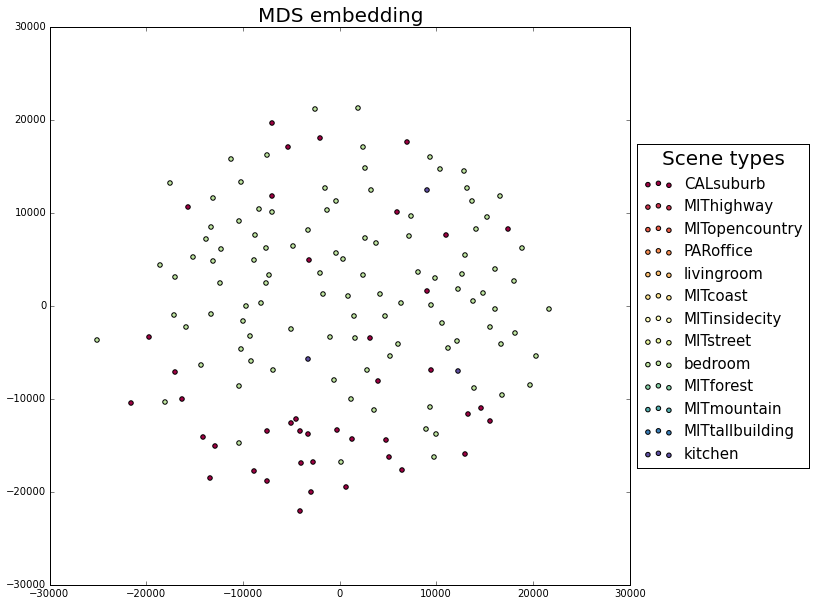

In [24]:
from sklearn.manifold import MDS
import csv
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)

X_train = np.load(X_train_filename)
X_test = np.load(X_test_filename)

plot_sample_size = 3500 # You can change this if you'd like to control how much is plotted. But you probably don't need to




X = np.concatenate((X_train, X_test))
num_X_train = len(X_train)

y = np.concatenate((y_train, y_test))




random_state = 123
comp_list = [2, 3]

for comp in comp_list:
    mds = MDS(n_components=comp)
    print "Fitting mds..."
    %time new_X = mds.fit_transform(X)
    new_X_train = new_X[:num_X_train]
    new_X_test = new_X[num_X_train:]

    feature_name = base_feature + "-mds-" + str(comp) +'-'+ str(neigh) + '-'
    out_train_file_name = "features/X_train-" + feature_name
    out_test_file_name = "features/X_test-" + feature_name
    out_model_file_name = "features/model-" + feature_name + '.p'
    out_model_component_file_name = "features/model-components-" + feature_name
    out_model_error_file_name = "features/model-error-" + feature_name

    np.save(out_train_file_name, new_X_train)
    np.save(out_test_file_name, new_X_test)
    pickle.dump(mds, open(out_model_file_name, 'wb'))
    embedding = mds.embedding_
    np.save(out_model_component_file_name,embedding)    
    
    err = np.array(iso.reconstruction_error())
    np.save(out_model_error_file_name, err)

    print "Training saved to ", out_train_file_name + ".npy"
    print "Test saved to ", out_test_file_name + ".npy"
    print "Model saved to ", out_model_file_name
    print "Model components saved to ", out_model_component_file_name + ".npy"


    os.system("say 'finished writing mds'")

    fig = plt.figure(figsize=(13,10))
    ax = plt.subplot(111)


    np.random.seed(random_state)
    random_indices = np.random.choice(len(new_X), size=plot_sample_size, replace=False)
    new_X_sample = new_X[random_indices]
    y_sample = y[random_indices]

    for i in range(13):
        indices = np.where(y_sample == i)[0]
        ax.scatter(new_X_sample[indices,0], new_X_sample[indices,1], c=colors[i], label=classes[i])
    plt.title("MDS embedding", fontsize=20)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

    # Put a legend to the right of the current axis
    leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Scene types', fontsize=15)

    plt.setp(leg.get_title(),fontsize=20)
    plt.show()



Fitting lle...
CPU times: user 60.1 ms, sys: 1.61 ms, total: 61.7 ms
Wall time: 61.3 ms
Training saved to  features/X_train-greyscale-lle-2-5-0.001.npy
Test saved to  features/X_test-greyscale-lle-2-5-0.001.npy
Model saved to  features/model-greyscale-lle-2-5-0.001.p
Model components saved to  features/model-components-greyscale-lle-2-5-0.001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  5 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


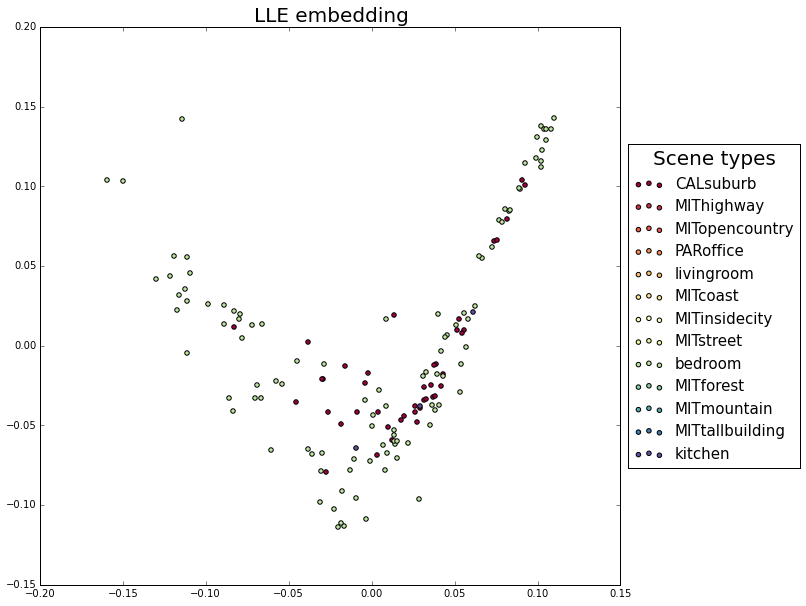

Fitting lle...
CPU times: user 67.8 ms, sys: 2.11 ms, total: 69.9 ms
Wall time: 69.5 ms
Training saved to  features/X_train-greyscale-lle-3-5-0.001.npy
Test saved to  features/X_test-greyscale-lle-3-5-0.001.npy
Model saved to  features/model-greyscale-lle-3-5-0.001.p
Model components saved to  features/model-components-greyscale-lle-3-5-0.001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  5 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


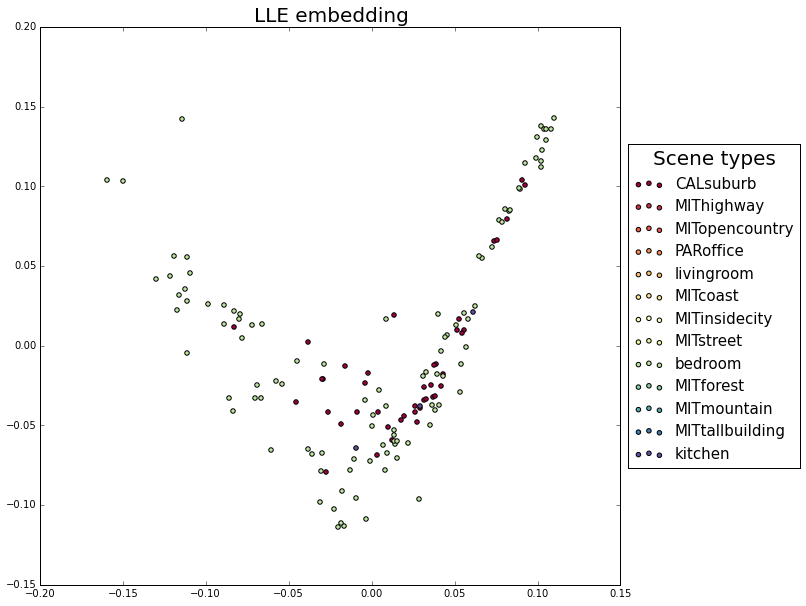

Fitting lle...
CPU times: user 73.3 ms, sys: 4.17 ms, total: 77.5 ms
Wall time: 77.2 ms
Training saved to  features/X_train-greyscale-lle-2-10-0.001.npy
Test saved to  features/X_test-greyscale-lle-2-10-0.001.npy
Model saved to  features/model-greyscale-lle-2-10-0.001.p
Model components saved to  features/model-components-greyscale-lle-2-10-0.001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  10 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


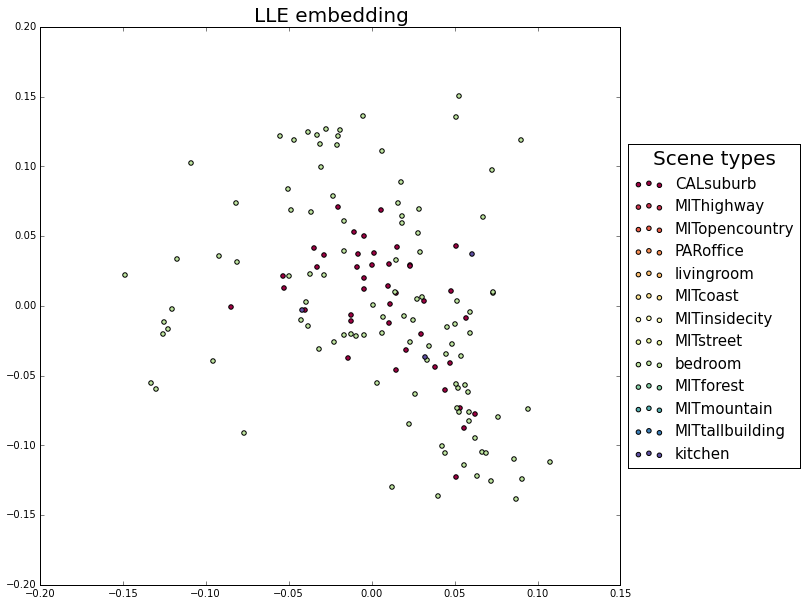

Fitting lle...
CPU times: user 67.8 ms, sys: 3.1 ms, total: 70.9 ms
Wall time: 70.5 ms
Training saved to  features/X_train-greyscale-lle-3-10-0.001.npy
Test saved to  features/X_test-greyscale-lle-3-10-0.001.npy
Model saved to  features/model-greyscale-lle-3-10-0.001.p
Model components saved to  features/model-components-greyscale-lle-3-10-0.001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  10 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


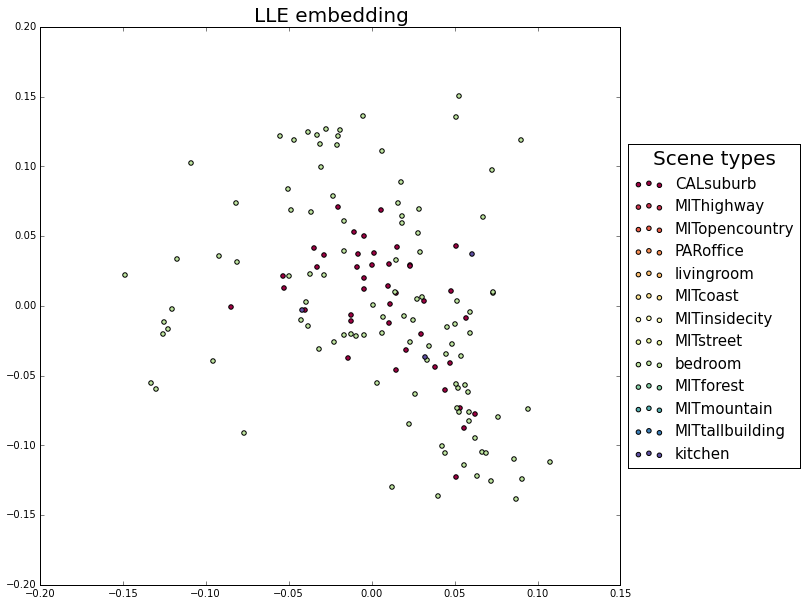

Fitting lle...
CPU times: user 120 ms, sys: 12.5 ms, total: 133 ms
Wall time: 135 ms
Training saved to  features/X_train-greyscale-lle-2-50-0.001.npy
Test saved to  features/X_test-greyscale-lle-2-50-0.001.npy
Model saved to  features/model-greyscale-lle-2-50-0.001.p
Model components saved to  features/model-components-greyscale-lle-2-50-0.001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  50 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


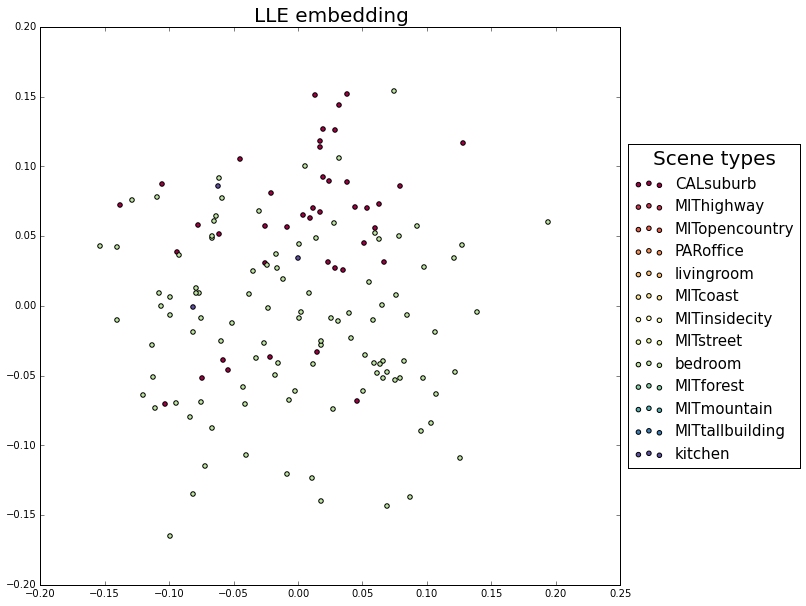

Fitting lle...
CPU times: user 102 ms, sys: 9.21 ms, total: 112 ms
Wall time: 111 ms
Training saved to  features/X_train-greyscale-lle-3-50-0.001.npy
Test saved to  features/X_test-greyscale-lle-3-50-0.001.npy
Model saved to  features/model-greyscale-lle-3-50-0.001.p
Model components saved to  features/model-components-greyscale-lle-3-50-0.001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  50 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


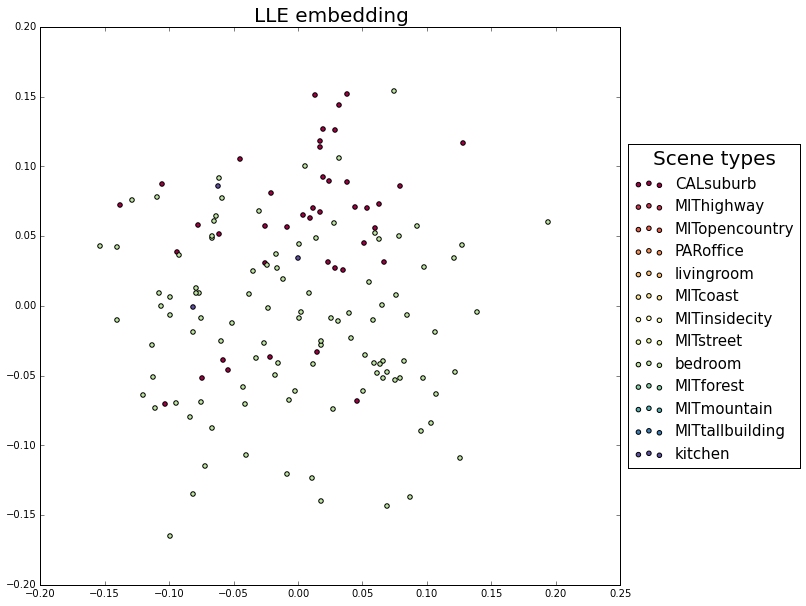

Fitting lle...
CPU times: user 65 ms, sys: 1.73 ms, total: 66.7 ms
Wall time: 66.1 ms
Training saved to  features/X_train-greyscale-lle-2-5-0.0001.npy
Test saved to  features/X_test-greyscale-lle-2-5-0.0001.npy
Model saved to  features/model-greyscale-lle-2-5-0.0001.p
Model components saved to  features/model-components-greyscale-lle-2-5-0.0001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  5 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


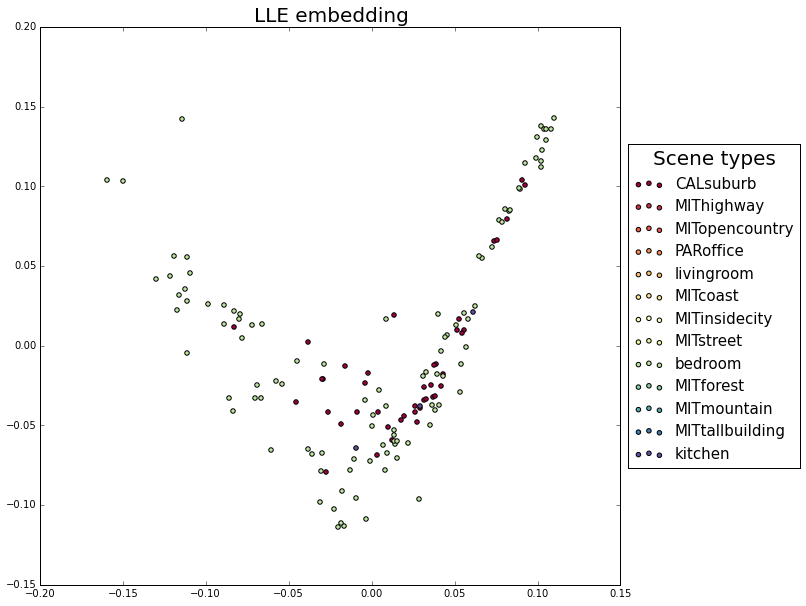

Fitting lle...
CPU times: user 57.4 ms, sys: 1.77 ms, total: 59.1 ms
Wall time: 59.3 ms
Training saved to  features/X_train-greyscale-lle-3-5-0.0001.npy
Test saved to  features/X_test-greyscale-lle-3-5-0.0001.npy
Model saved to  features/model-greyscale-lle-3-5-0.0001.p
Model components saved to  features/model-components-greyscale-lle-3-5-0.0001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  5 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


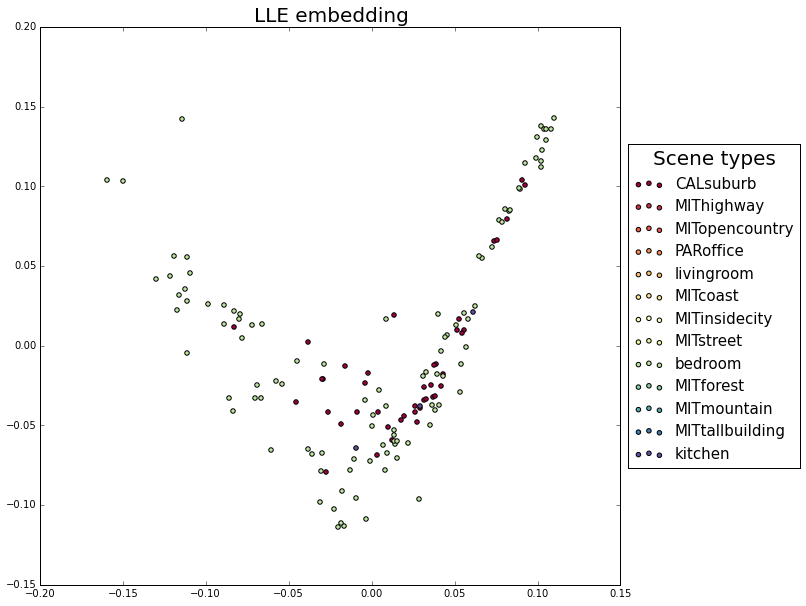

Fitting lle...
CPU times: user 66.3 ms, sys: 3.31 ms, total: 69.6 ms
Wall time: 69.6 ms
Training saved to  features/X_train-greyscale-lle-2-10-0.0001.npy
Test saved to  features/X_test-greyscale-lle-2-10-0.0001.npy
Model saved to  features/model-greyscale-lle-2-10-0.0001.p
Model components saved to  features/model-components-greyscale-lle-2-10-0.0001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  10 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


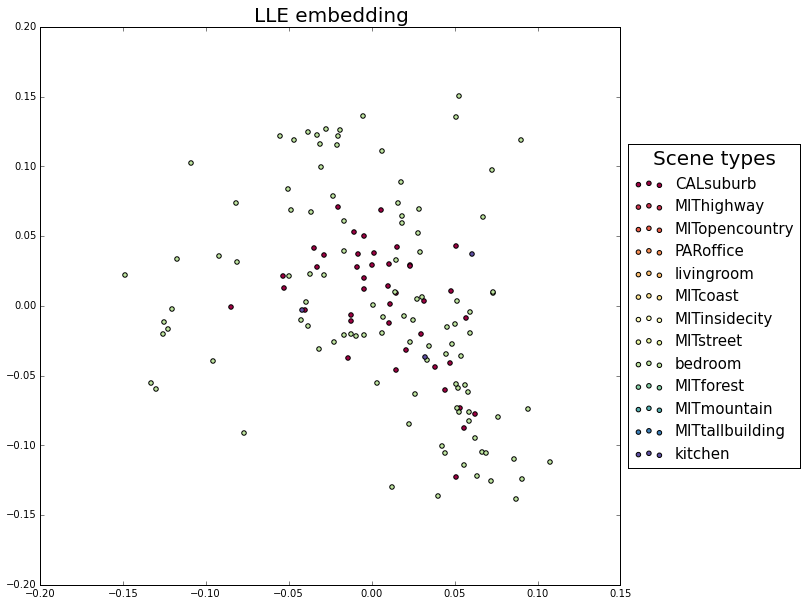

Fitting lle...
CPU times: user 68.7 ms, sys: 3.48 ms, total: 72.2 ms
Wall time: 71.6 ms
Training saved to  features/X_train-greyscale-lle-3-10-0.0001.npy
Test saved to  features/X_test-greyscale-lle-3-10-0.0001.npy
Model saved to  features/model-greyscale-lle-3-10-0.0001.p
Model components saved to  features/model-components-greyscale-lle-3-10-0.0001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  10 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


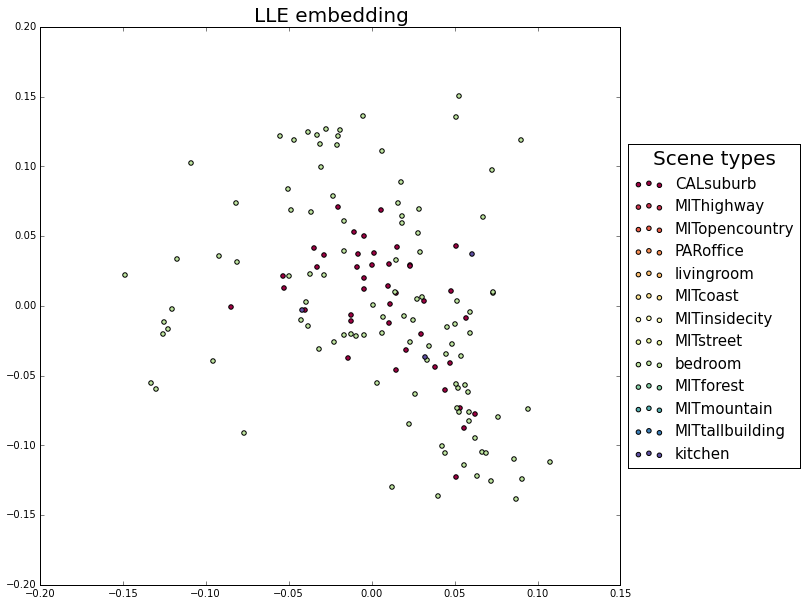

Fitting lle...
CPU times: user 108 ms, sys: 9.42 ms, total: 118 ms
Wall time: 117 ms
Training saved to  features/X_train-greyscale-lle-2-50-0.0001.npy
Test saved to  features/X_test-greyscale-lle-2-50-0.0001.npy
Model saved to  features/model-greyscale-lle-2-50-0.0001.p
Model components saved to  features/model-components-greyscale-lle-2-50-0.0001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  50 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


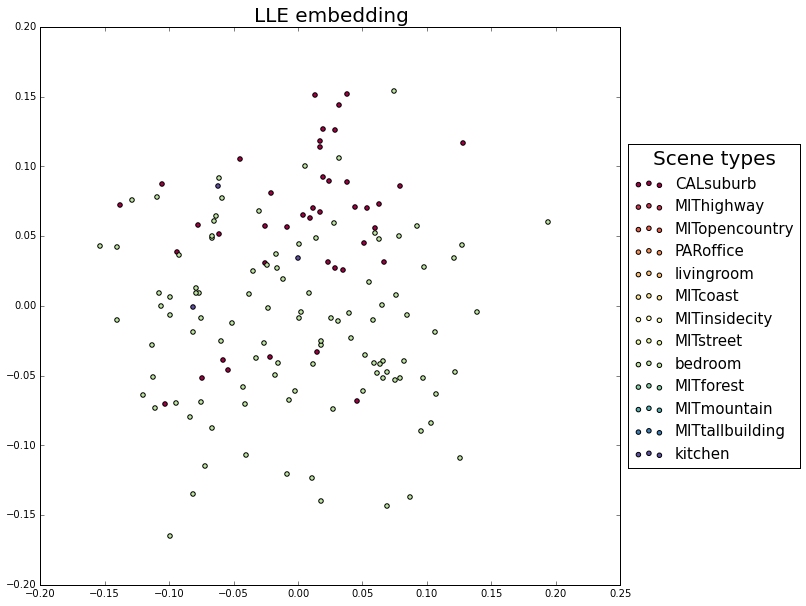

Fitting lle...
CPU times: user 111 ms, sys: 10.5 ms, total: 121 ms
Wall time: 122 ms
Training saved to  features/X_train-greyscale-lle-3-50-0.0001.npy
Test saved to  features/X_test-greyscale-lle-3-50-0.0001.npy
Model saved to  features/model-greyscale-lle-3-50-0.0001.p
Model components saved to  features/model-components-greyscale-lle-3-50-0.0001.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  50 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


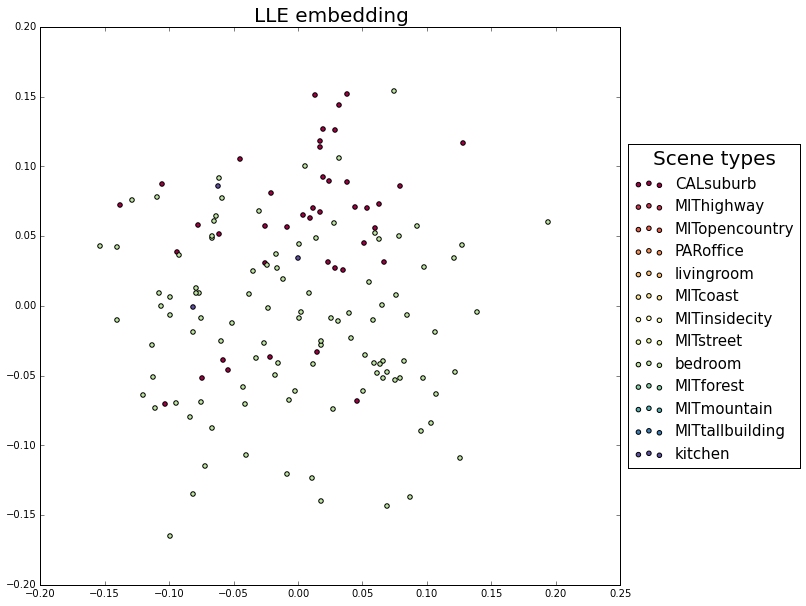

Fitting lle...
CPU times: user 66.4 ms, sys: 2.56 ms, total: 69 ms
Wall time: 70 ms
Training saved to  features/X_train-greyscale-lle-2-5-1e-05.npy
Test saved to  features/X_test-greyscale-lle-2-5-1e-05.npy
Model saved to  features/model-greyscale-lle-2-5-1e-05.p
Model components saved to  features/model-components-greyscale-lle-2-5-1e-05.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  5 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


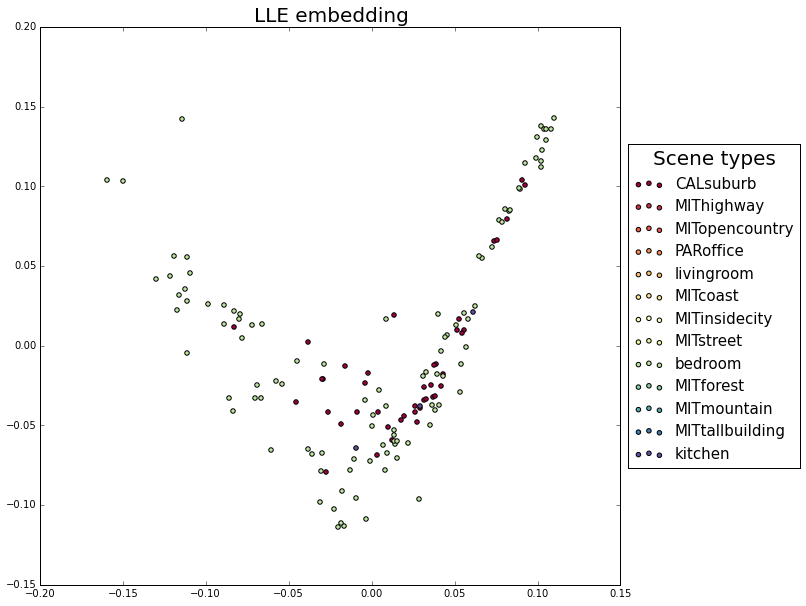

Fitting lle...
CPU times: user 74.7 ms, sys: 2.36 ms, total: 77.1 ms
Wall time: 77.8 ms
Training saved to  features/X_train-greyscale-lle-3-5-1e-05.npy
Test saved to  features/X_test-greyscale-lle-3-5-1e-05.npy
Model saved to  features/model-greyscale-lle-3-5-1e-05.p
Model components saved to  features/model-components-greyscale-lle-3-5-1e-05.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  5 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


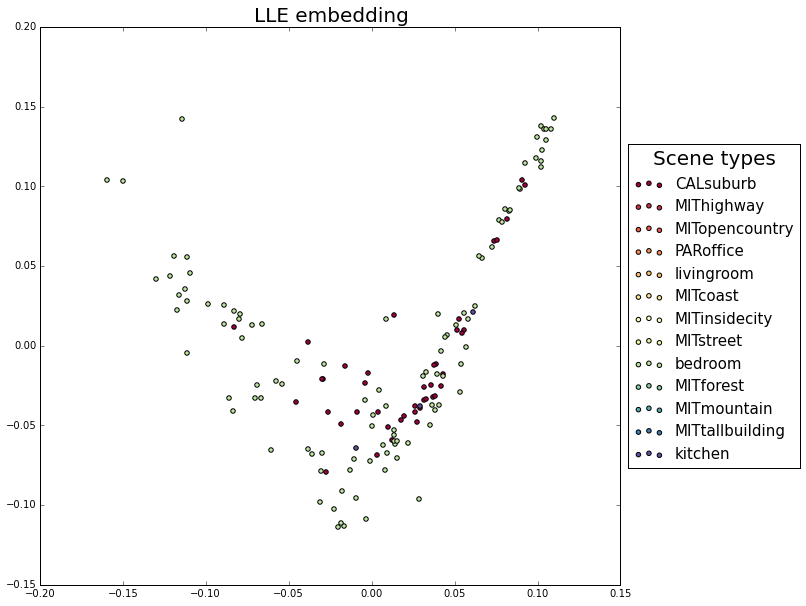

Fitting lle...
CPU times: user 83.2 ms, sys: 5.97 ms, total: 89.2 ms
Wall time: 95.1 ms
Training saved to  features/X_train-greyscale-lle-2-10-1e-05.npy
Test saved to  features/X_test-greyscale-lle-2-10-1e-05.npy
Model saved to  features/model-greyscale-lle-2-10-1e-05.p
Model components saved to  features/model-components-greyscale-lle-2-10-1e-05.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  10 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


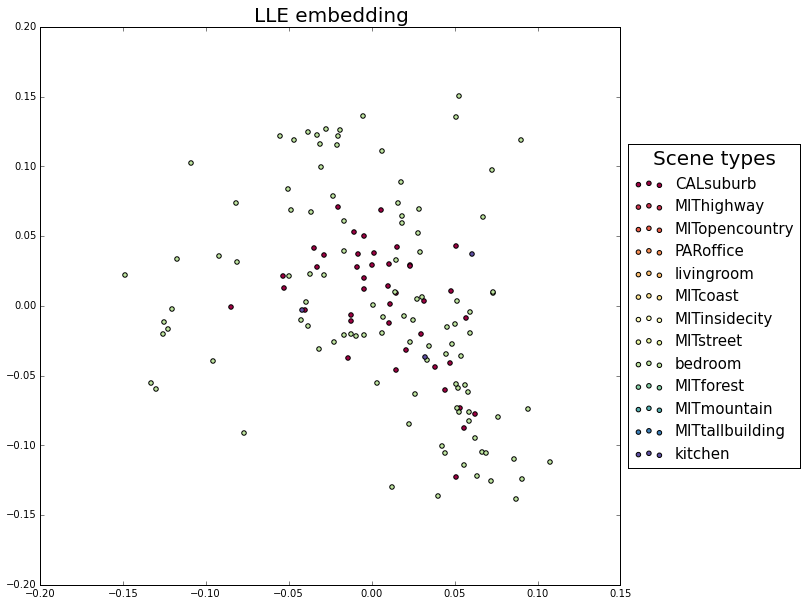

Fitting lle...
CPU times: user 64.4 ms, sys: 2.76 ms, total: 67.2 ms
Wall time: 67 ms
Training saved to  features/X_train-greyscale-lle-3-10-1e-05.npy
Test saved to  features/X_test-greyscale-lle-3-10-1e-05.npy
Model saved to  features/model-greyscale-lle-3-10-1e-05.p
Model components saved to  features/model-components-greyscale-lle-3-10-1e-05.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  10 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


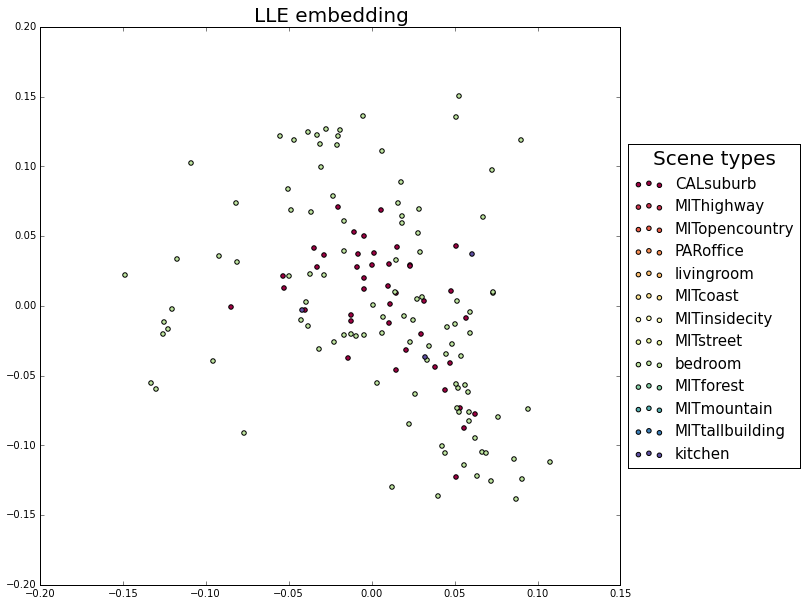

Fitting lle...
CPU times: user 109 ms, sys: 9.57 ms, total: 119 ms
Wall time: 118 ms
Training saved to  features/X_train-greyscale-lle-2-50-1e-05.npy
Test saved to  features/X_test-greyscale-lle-2-50-1e-05.npy
Model saved to  features/model-greyscale-lle-2-50-1e-05.p
Model components saved to  features/model-components-greyscale-lle-2-50-1e-05.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  50 For comp,  2 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


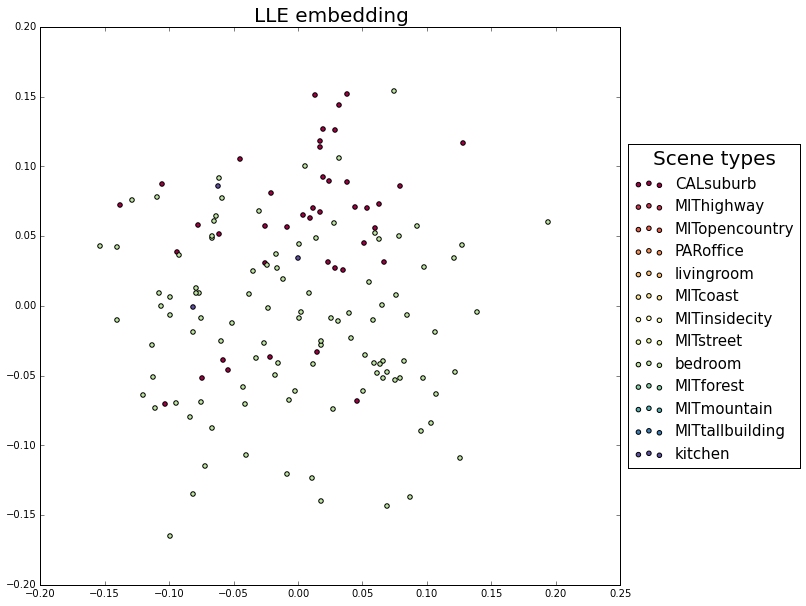

Fitting lle...
CPU times: user 111 ms, sys: 9.75 ms, total: 121 ms
Wall time: 121 ms
Training saved to  features/X_train-greyscale-lle-3-50-1e-05.npy
Test saved to  features/X_test-greyscale-lle-3-50-1e-05.npy
Model saved to  features/model-greyscale-lle-3-50-1e-05.p
Model components saved to  features/model-components-greyscale-lle-3-50-1e-05.npy
Error saved to  features/model-error-greyscale-mds-2-5-.npy
For neighbors,  50 For comp,  3 VREconstruction error e explained is  58331983.6321
Average error per image  583319.836321
Average error per image pixel  1166.63967264


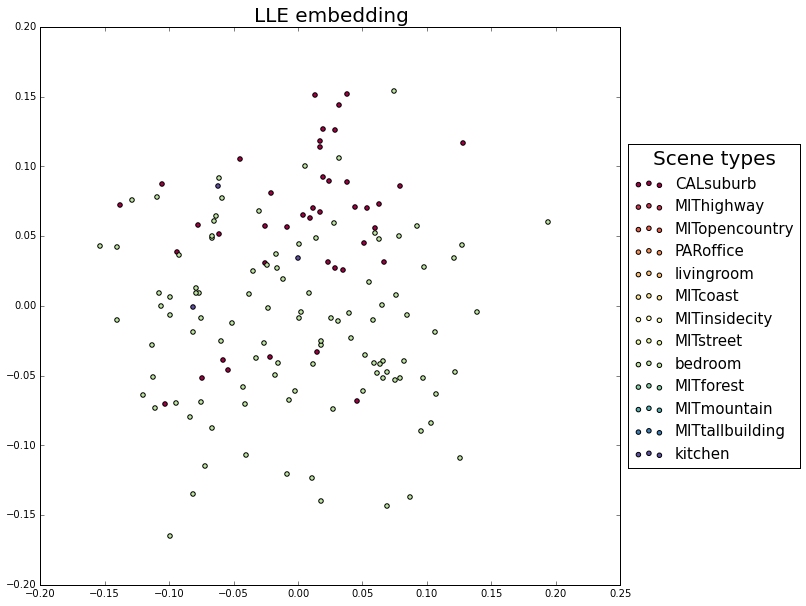

In [27]:
from sklearn.manifold import LocallyLinearEmbedding
import csv
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



y_train = np.load(y_train_filename)
y_test = np.load(y_test_filename)

X_train = np.load(X_train_filename)
X_test = np.load(X_test_filename)


plot_sample_size = 3500 # You can change this if you'd like to control how much is plotted. But you probably don't need to


X = np.concatenate((X_train, X_test))
num_X_train = len(X_train)

y = np.concatenate((y_train, y_test))




random_state = 123
comp_list = [2, 3]
#neigh_list = [5, 10, 50]
neigh_list = [5, 10, 50]
reg_list = [0.001, 0.0001, 0.00001]
for reg in reg_list:
    for neigh in neigh_list:
        for comp in comp_list:
        
            lle = LocallyLinearEmbedding(n_components=comp, n_neighbors = neigh, reg=reg)
            print "Fitting lle..."
            %time new_X = lle.fit_transform(X)
            new_X_train = new_X[:num_X_train]
            new_X_test = new_X[num_X_train:]

            feature_name = base_feature + "-lle-" + str(comp) +'-'+ str(neigh) + '-' + str(reg)
            out_train_file_name = "features/X_train-" + feature_name
            out_test_file_name = "features/X_test-" + feature_name
            out_model_file_name = "features/model-" + feature_name + '.p'
            out_model_component_file_name = "features/model-components-" + feature_name

            np.save(out_train_file_name, new_X_train)
            np.save(out_test_file_name, new_X_test)
            pickle.dump(lle, open(out_model_file_name, 'wb'))
            embedding = lle.embedding_
            np.save(out_model_component_file_name,embedding)        

            print "Training saved to ", out_train_file_name + ".npy"
            print "Test saved to ", out_test_file_name + ".npy"
            print "Model saved to ", out_model_file_name
            print "Model components saved to ", out_model_component_file_name + ".npy"
            print "Error saved to ", out_model_error_file_name + ".npy"    

            print "For neighbors, ", neigh, "For comp, ", comp, "VREconstruction error e explained is ",err
            print "Average error per image ", err/len(X_train)
            print "Average error per image pixel ",  err/(len(X_train) * len(X_train[0]))

            

            os.system("say 'finished writing lle'")

            fig = plt.figure(figsize=(13,10))
            ax = plt.subplot(111)


            np.random.seed(random_state)
            random_indices = np.random.choice(len(new_X), size=plot_sample_size, replace=False)
            new_X_sample = new_X[random_indices]
            y_sample = y[random_indices]

            for i in range(13):
                indices = np.where(y_sample == i)[0]
                ax.scatter(new_X_sample[indices,0], new_X_sample[indices,1], c=colors[i], label=classes[i])
            plt.title("LLE embedding", fontsize=20)

            box = ax.get_position()
            ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

            # Put a legend to the right of the current axis
            leg = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Scene types', fontsize=15)

            plt.setp(leg.get_title(),fontsize=20)
            plt.show()



# DOn't worry about these, these are just old code to conver to numpy arrays

# Convert to flattened base_feature pixel vector, write to npy

In [3]:
load_folder = "resized_data"

np_base_feature_filename = "features/13Scenes-" + base_feature

#Files are of the form class_numberintheclass.npy

base_feature_matrix = []

for filename in os.listdir(load_folder):    
    full_filename = load_folder + '/' + filename
    image = np.load(full_filename)
    
    image = image.flatten()
    
    base_feature_matrix.append(image)
    
base_feature_matrix = np.array(base_feature_matrix)

print "Shape of " + base_feature "_matrix is ", base_feature_matrix.shape

np.save(np_base_feature_filename, base_feature_matrix)


Shape of greyscale_matrix is  (3859, 66420)


# Write the overall ID dict file in features

In [8]:
import collections
import os
import numpy as np

load_folder = "resized_data"
out_file_name = "features/ID_list.csv"
labels_file_name = "features/labels"

#Files are of the form class_numberintheclass.npy

IDdict_list = []
labels = []

i = 0
for filename in os.listdir(load_folder):
    class_name = filename.split("_")[0]
    class_label = classes.index(class_name)
    
    number_in_the_class = int(filename.split("_")[1].split(".npy")[0])

    IDdict = collections.OrderedDict()
    
    IDdict["Image_Name"] = class_name + "_" + str(number_in_the_class)
    IDdict["Image_Number"] = number_in_the_class
    IDdict["Class_Name"] = class_name
    IDdict["Class_Label"] = class_label
    IDdict["Index"] = i
    
    labels.append(class_label)
    
    IDdict_list.append(IDdict)
    i += 1



#WRite the file out
with open(out_file_name, 'w') as csvfile:
    writer = csv.DictWriter(csvfile, fieldnames=IDdict_list[0].keys())
    writer.writeheader()
    for IDdict in IDdict_list:
        writer.writerow(IDdict)

            
# Save the npy file
labels = np.array(labels)
np.save(labels_file_name, labels)

# Convert to base_feature pixel vector, write to human-readable csv

In [3]:
load_folder = "resized_data"

#Files are of the form class_numberintheclass.npy

image_lists = []

for filename in os.listdir(load_folder):
    
    image_class = filename.split("_")[0]
    
    number_in_the_class = int(filename.split("_")[1].split(".npy")[0])
    
    full_filename = load_folder + '/' + filename
    image = np.load(full_filename)
    image_lists.append([image_class, number_in_the_class, image])
    

In [3]:


out_file_name = "features/13Scenes-" + base_feature ".csv"


import csv

feature_name = base_feature

num_features = len(image_lists[0][2])

print "number of features is ", num_features

feature_header = [feature_name + str(i+1) for i in range(num_features)]
with open(out_file_name, 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image_Name", "Image_Number", "Class_Name", "Class_Label"] + feature_header)
    for image_list in image_lists:
        image_name = str(image_list[0]) + "_" + str(image_list[1])
        image_number = image_list[1]
        class_name = image_list[0]
        class_label = classes.index(class_name)
        features = image_list[2]
        
        out_row = [image_name, image_number, class_name, class_label] + list(features)
        
        writer.writerow(out_row)



number of features is  66420


KeyboardInterrupt: 

# Do PCA (deprecated, was over all data)

In [3]:
from sklearn.decomposition import PCA, RandomizedPCA, TruncatedSVD
import csv

comp_list = [100, 500, 1000]
for comp in comp_list:
    pca = PCA(n_components=comp)
    print "Fitting PCA..."
    %time pca.fit(base_feature_matrix)
    print "Transforming PCA..."
    %time new_matrix = pca.transform(base_feature_matrix)
    num_features = len(new_matrix[0])
    print "number of features is ", num_features
    
    feature_name = base_feature + "-pca-" + str(comp) +'-'
    out_file_name = "features/13Scenes-" + feature_name
    
    np.save(out_file_name, new_matrix)
    print "Matrix saved to ", out_file_name + ".npy"
    
    os.system("say 'finished writing pca'")
    # Save variance
    var = np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
    
    print "For comp, ", comp, "Variance explained is ", var
    np.save(out_file_name+"variance", var)

    print "Variance saved to ", out_file_name + "variance" + ".npy"
    
    components = pca.components_
    
    np.save(out_file_name+"components",components)
    print "Comopnents saved to ", out_file_name + "components" + ".npy"


Fitting PCA...
CPU times: user 14min 28s, sys: 1min 38s, total: 16min 6s
Wall time: 8min 28s
Transforming PCA...
CPU times: user 7.76 s, sys: 23.3 s, total: 31.1 s
Wall time: 1min 27s
number of features is  100
Matrix saved to  features/13Scenes-greyscale-pca-100-.npy
For comp,  100 Variance explained is  [ 19.74  33.21  39.95  45.02  48.29  51.13  53.09  54.83  56.21  57.49
  58.65  59.72  60.7   61.57  62.34  63.07  63.68  64.26  64.79  65.31
  65.83  66.33  66.8   67.24  67.67  68.06  68.42  68.76  69.08  69.4
  69.71  70.    70.28  70.55  70.82  71.08  71.32  71.56  71.79  72.01
  72.23  72.44  72.64  72.84  73.04  73.23  73.41  73.58  73.75  73.92
  74.08  74.24  74.4   74.55  74.7   74.85  75.    75.14  75.28  75.42
  75.55  75.68  75.81  75.94  76.06  76.18  76.3   76.42  76.54  76.65
  76.76  76.87  76.98  77.09  77.19  77.29  77.39  77.49  77.59  77.69
  77.78  77.87  77.96  78.05  78.14  78.23  78.32  78.41  78.5   78.58
  78.66  78.74  78.82  78.9   78.98  79.06  79.14  79.2